In [1]:
import pandas as pd
import numpy as np
import operator as op

#Preprocessing
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

#Clustering
from matplotlib import pyplot as plt
%matplotlib inline
from scipy.linalg import norm
from scipy.spatial.distance import euclidean
from sklearn.cluster import KMeans, BisectingKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from deep_translator import GoogleTranslator
from sklearn import datasets

#WordCloud
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from wordcloud import STOPWORDS

#BiLSTM
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dropout
from keras.optimizers import SGD, Adam
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import Adamax
import tensorflow as tf

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import pingouin as pg

# Loading of the Dataset in Google Drive

In [2]:
#Load the dataset csv file coming from gdrive
url = 'https://drive.google.com/file/d/18ds8uNdxhSjb39jvWnepdstfFPv64ClH/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id=' + url.split('/')[-2]
internet_dataset = pd.read_csv(path)
internet_dataset

,Unnamed: 0,Time,User,Sentiment,Tweet
0,0,2022-07-25 04:48:14+00:00,qverubin,Negative,@Converge_CSU @instagram tf is going on????
1,1,2022-07-25 04:46:05+00:00,dludvian,Negative,Fix your goddamn bullshit shitty crappy fuckin...
2,2,2022-07-25 04:36:12+00:00,CRANKiT2U,Negative,After more than 17hrs of reachingout and troub...
3,3,2022-07-25 04:33:02+00:00,lacson_go,Neutral,@Converge_CSU hello?
4,4,2022-07-25 04:30:07+00:00,pamelamazing13,Negative,@TimothyTam725 @Converge_CSU @ExperienceCNVRG ...
...,...,...,...,...,...
9985,9985,2022-08-06 10:59:28+00:00,ericccvlogs,Negative,@talk2GLOBE Even in private message ayaw niyo ...
9986,9986,2022-08-06 10:54:25+00:00,ericccvlogs,Negative,@talk2GLOBE Serbisyong TAE!!!
9987,9987,2022-08-06 10:53:58+00:00,ericccvlogs,Negative,@talk2GLOBE Serbisyong TAE!!!!
9988,9988,2022-08-06 10:48:34+00:00,kennethyau,Neutral,@talk2GLOBE Kindly check your DM. Thank you


In [3]:
internet_dataset = internet_dataset[['Sentiment', 'Tweet']]
internet_dataset

,Sentiment,Tweet
0,Negative,@Converge_CSU @instagram tf is going on????
1,Negative,Fix your goddamn bullshit shitty crappy fuckin...
2,Negative,After more than 17hrs of reachingout and troub...
3,Neutral,@Converge_CSU hello?
4,Negative,@TimothyTam725 @Converge_CSU @ExperienceCNVRG ...
...,...,...
9985,Negative,@talk2GLOBE Even in private message ayaw niyo ...
9986,Negative,@talk2GLOBE Serbisyong TAE!!!
9987,Negative,@talk2GLOBE Serbisyong TAE!!!!
9988,Neutral,@talk2GLOBE Kindly check your DM. Thank you


# Preprocessing

In [4]:
#Remove Twitter Usernames and Special Characters in Tweets
def remove_usernames_links(tweet):
    #Twitter Names
    tweet = re.sub('@[^\s]+','',tweet)
    tweet = re.sub('http[^\s]+','',tweet)
    #Special Characters
    tweet = re.sub(r"[^a-zA-Z0-9]+", ' ', tweet)
    return tweet

internet_dataset['Tweet'] = internet_dataset['Tweet'].apply(remove_usernames_links)


<ipython-input-4-f0cd1fb7b515>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  internet_dataset['Tweet'] = internet_dataset['Tweet'].apply(remove_usernames_links)


In [5]:
#Lowercase Tweets
internet_dataset['Tweet'] = internet_dataset['Tweet'].str.lower()
internet_dataset

<ipython-input-5-4148ee898ca2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  internet_dataset['Tweet'] = internet_dataset['Tweet'].str.lower()


,Sentiment,Tweet
0,Negative,tf is going on
1,Negative,fix your goddamn bullshit shitty crappy fuckin...
2,Negative,after more than 17hrs of reachingout and troub...
3,Neutral,hello
4,Negative,i will definitely do this and will ask for my...
...,...,...
9985,Negative,even in private message ayaw niyo magresponse...
9986,Negative,serbisyong tae
9987,Negative,serbisyong tae
9988,Neutral,kindly check your dm thank you


In [6]:
#Remove Numbers in Tweets
internet_dataset['Tweet'] = internet_dataset['Tweet'].str.replace('\d+', '')
internet_dataset

<ipython-input-6-8721ea5c7dca>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  internet_dataset['Tweet'] = internet_dataset['Tweet'].str.replace('\d+', '')
<ipython-input-6-8721ea5c7dca>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  internet_dataset['Tweet'] = internet_dataset['Tweet'].str.replace('\d+', '')


,Sentiment,Tweet
0,Negative,tf is going on
1,Negative,fix your goddamn bullshit shitty crappy fuckin...
2,Negative,after more than hrs of reachingout and trouble...
3,Neutral,hello
4,Negative,i will definitely do this and will ask for my...
...,...,...
9985,Negative,even in private message ayaw niyo magresponse...
9986,Negative,serbisyong tae
9987,Negative,serbisyong tae
9988,Neutral,kindly check your dm thank you


In [7]:
#Custom Stopwords
stopwords = ['ourselves', 'hers', 'between', 'yourself', 'but', 'again', 'there', 'about', 
             'once', 'during', 'out', 'very', 'having', 'with', 'they', 'own', 'an', 'be', 
             'some', 'for', 'do', 'its', 'yours', 'such', 'into', 'of', 'most', 'itself', 'other', 
             'off', 'is', 's', 'am', 'or', 'who', 'as', 'from', 'him', 'each', 'the', 'themselves', 
             'until', 'below', 'are', 'we', 'these', 'your', 'his', 'through', 'nor', 'me', 'were', 
             'her', 'more', 'himself', 'this', 'should', 'our', 'their', 'while', 'above', 'both', 
             'up', 'to', 'ours', 'had', 'she', 'all',  'when', 'at', 'any', 'before', 'them', 'same', 
             'and', 'been', 'have', 'in', 'will', 'on', 'does', 'yourselves', 'then', 'that', 
             'because', 'what', 'over', 'why', 'so', 'can', 'did', 'now', 'under', 'he', 'you', 
             'herself', 'has', 'just', 'where', 'too', 'only', 'myself', 'which', 'those', 'i', 
             'after', 'few', 'whom', 'being', 'if', 'theirs', 'my', 'against', 'a', 'by', 'doing', 
             'it', 'how', 'further', 'was', 'here', 'than', 'hello', 'hi', 'please', 'pls', 'daw', 
             'namang', 're', 'they', 'lang', 'namin', 'kase', 'kaming', 'anu', 'rin', 'din', 'raw', 
             'pano', 'may', 'tas', 'anong', 'ako', 'sa', 'akin', 'ko', 'aking', 'sarili', 'kami', 
             'atin', 'ang', 'aming', 'amin', 'ating', 'ka', 'iyong', 'iyo', 'inyong', 'siya', 'kanya', 
             'mismo', 'ito', 'nito', 'kanyang', 'sila', 'nila', 'kanila', 'kanilang', 'kung', 'ano', 
             'alin', 'sino', 'kanino', 'na', 'mga', 'iyon', 'am', 'ay', 'maging', 'naging', 'mayroon', 
             'may', 'nagkaroon', 'pagkakaroon', 'gumawa', 'ginagawa', 'ginawa', 'paggawa', 'ibig', 
             'dapat', 'maaari', 'marapat', 'kong', 'ikaw', 'tayo', 'namin', 'gusto', 'nais', 'niyang', 
             'nilang', 'niya', 'ginawang', 'gagawin', 'maaaring', 'sabihin', 'narito', 'kapag', 'ni', 
             'nasaan', 'bakit', 'paano', 'kailangan', 'katiyakan', 'isang', 'at', 'pero', 'o', 'dahil', 
             'bilang', 'hanggang', 'habang', 'ng', 'pamamagitan', 'para', 'tungkol', 'laban', 'pagitan', 
             'panahon', 'bago', 'pagkatapos', 'itaas', 'ibaba', 'mula', 'pataas', 'pababa', 'palabas', 
             'ibabaw', 'ilalim', 'muli', 'pa', 'minsan', 'dito', 'doon', 'saan', 'lahat', 'anumang', 
             'kapwa', 'bawat', 'ilan', 'karamihan', 'iba', 'tulad', 'lamang', 'pareho', 'kaya', 'kaysa', 
             'masyado', 'napaka', 'isa', 'bababa', 'kulang', 'marami', 'ngayon', 'kailanman', 'sabi', 
             'nabanggit', 'din', 'kumuha', 'pumunta', 'pumupunta', 'ilagay', 'makita', 'nakita', 'katulad', 
             'mahusay', 'likod', 'kahit', 'paraan', 'noon', 'gayunman', 'dalawa', 'tatlo', 'apat', 'lima', 
             'una', 'pangalawa', 'po', 'na', 'ah', 'pi']

In [8]:
#Removal of Stopwords
internet_dataset['Tweet'] = internet_dataset['Tweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))
internet_dataset

<ipython-input-8-5b9adc8bfc85>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  internet_dataset['Tweet'] = internet_dataset['Tweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))


,Sentiment,Tweet
0,Negative,tf going
1,Negative,fix goddamn bullshit shitty crappy fucking bul...
2,Negative,hrs reachingout troubleshooting possible ways ...
3,Neutral,
4,Negative,definitely ask family friends report
...,...,...
9985,Negative,even private message ayaw niyo magresponse kla...
9986,Negative,serbisyong tae
9987,Negative,serbisyong tae
9988,Neutral,kindly check dm thank


In [9]:
#Tokenize Tweets
internet_dataset['Tokenize'] = internet_dataset['Tweet'].apply(word_tokenize) 

<ipython-input-9-fb89e4a6d685>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  internet_dataset['Tokenize'] = internet_dataset['Tweet'].apply(word_tokenize)


In [10]:
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.WordNetLemmatizer()

#Lemmatization
def lemmatize_text(Tweet):
     return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(Tweet)]

In [11]:
internet_dataset['Lemmatize'] = internet_dataset['Tweet'].apply(lemmatize_text)

<ipython-input-11-21e97b6378e4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  internet_dataset['Lemmatize'] = internet_dataset['Tweet'].apply(lemmatize_text)


In [12]:
internet_dataset

,Sentiment,Tweet,Tokenize,Lemmatize
0,Negative,tf going,"[tf, going]","[tf, going]"
1,Negative,fix goddamn bullshit shitty crappy fucking bul...,"[fix, goddamn, bullshit, shitty, crappy, fucki...","[fix, goddamn, bullshit, shitty, crappy, fucki..."
2,Negative,hrs reachingout troubleshooting possible ways ...,"[hrs, reachingout, troubleshooting, possible, ...","[hr, reachingout, troubleshooting, possible, w..."
3,Neutral,,[],[]
4,Negative,definitely ask family friends report,"[definitely, ask, family, friends, report]","[definitely, ask, family, friend, report]"
...,...,...,...,...
9985,Negative,even private message ayaw niyo magresponse kla...,"[even, private, message, ayaw, niyo, magrespon...","[even, private, message, ayaw, niyo, magrespon..."
9986,Negative,serbisyong tae,"[serbisyong, tae]","[serbisyong, tae]"
9987,Negative,serbisyong tae,"[serbisyong, tae]","[serbisyong, tae]"
9988,Neutral,kindly check dm thank,"[kindly, check, dm, thank]","[kindly, check, dm, thank]"


In [13]:
#Replace Labels for Negative, Neutral, Positive to [0, 1, 2]
internet_dataset['Sentiment'] = internet_dataset['Sentiment'].replace(['Negative'], 0)
internet_dataset['Sentiment'] = internet_dataset['Sentiment'].replace(['Neutral'], 1)
internet_dataset['Sentiment'] = internet_dataset['Sentiment'].replace(['Positive'], 2)

<ipython-input-13-927a6ac7a0b9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  internet_dataset['Sentiment'] = internet_dataset['Sentiment'].replace(['Negative'], 0)
<ipython-input-13-927a6ac7a0b9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  internet_dataset['Sentiment'] = internet_dataset['Sentiment'].replace(['Neutral'], 1)
<ipython-input-13-927a6ac7a0b9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

In [14]:
#Transform empty string to NAN
internet_dataset = internet_dataset.replace(r'^\s*$', np.nan, regex=True)
internet_dataset

,Sentiment,Tweet,Tokenize,Lemmatize
0,0,tf going,"[tf, going]","[tf, going]"
1,0,fix goddamn bullshit shitty crappy fucking bul...,"[fix, goddamn, bullshit, shitty, crappy, fucki...","[fix, goddamn, bullshit, shitty, crappy, fucki..."
2,0,hrs reachingout troubleshooting possible ways ...,"[hrs, reachingout, troubleshooting, possible, ...","[hr, reachingout, troubleshooting, possible, w..."
3,1,NaN,[],[]
4,0,definitely ask family friends report,"[definitely, ask, family, friends, report]","[definitely, ask, family, friend, report]"
...,...,...,...,...
9985,0,even private message ayaw niyo magresponse kla...,"[even, private, message, ayaw, niyo, magrespon...","[even, private, message, ayaw, niyo, magrespon..."
9986,0,serbisyong tae,"[serbisyong, tae]","[serbisyong, tae]"
9987,0,serbisyong tae,"[serbisyong, tae]","[serbisyong, tae]"
9988,1,kindly check dm thank,"[kindly, check, dm, thank]","[kindly, check, dm, thank]"


In [15]:
#Drop NAN values
internet_dataset = internet_dataset.dropna()
internet_dataset

,Sentiment,Tweet,Tokenize,Lemmatize
0,0,tf going,"[tf, going]","[tf, going]"
1,0,fix goddamn bullshit shitty crappy fucking bul...,"[fix, goddamn, bullshit, shitty, crappy, fucki...","[fix, goddamn, bullshit, shitty, crappy, fucki..."
2,0,hrs reachingout troubleshooting possible ways ...,"[hrs, reachingout, troubleshooting, possible, ...","[hr, reachingout, troubleshooting, possible, w..."
4,0,definitely ask family friends report,"[definitely, ask, family, friends, report]","[definitely, ask, family, friend, report]"
5,1,work haha,"[work, haha]","[work, haha]"
...,...,...,...,...
9985,0,even private message ayaw niyo magresponse kla...,"[even, private, message, ayaw, niyo, magrespon...","[even, private, message, ayaw, niyo, magrespon..."
9986,0,serbisyong tae,"[serbisyong, tae]","[serbisyong, tae]"
9987,0,serbisyong tae,"[serbisyong, tae]","[serbisyong, tae]"
9988,1,kindly check dm thank,"[kindly, check, dm, thank]","[kindly, check, dm, thank]"


In [16]:
#Drop Tweet Duplicates
internet_dataset['Tweet'] = internet_dataset['Tweet'].drop_duplicates()
internet_dataset

<ipython-input-16-0a1dc002eee3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  internet_dataset['Tweet'] = internet_dataset['Tweet'].drop_duplicates()


,Sentiment,Tweet,Tokenize,Lemmatize
0,0,tf going,"[tf, going]","[tf, going]"
1,0,fix goddamn bullshit shitty crappy fucking bul...,"[fix, goddamn, bullshit, shitty, crappy, fucki...","[fix, goddamn, bullshit, shitty, crappy, fucki..."
2,0,hrs reachingout troubleshooting possible ways ...,"[hrs, reachingout, troubleshooting, possible, ...","[hr, reachingout, troubleshooting, possible, w..."
4,0,definitely ask family friends report,"[definitely, ask, family, friends, report]","[definitely, ask, family, friend, report]"
5,1,work haha,"[work, haha]","[work, haha]"
...,...,...,...,...
9985,0,even private message ayaw niyo magresponse kla...,"[even, private, message, ayaw, niyo, magrespon...","[even, private, message, ayaw, niyo, magrespon..."
9986,0,serbisyong tae,"[serbisyong, tae]","[serbisyong, tae]"
9987,0,NaN,"[serbisyong, tae]","[serbisyong, tae]"
9988,1,kindly check dm thank,"[kindly, check, dm, thank]","[kindly, check, dm, thank]"


In [17]:
#Drop NAN values
internet_dataset = internet_dataset.dropna()
internet_dataset

,Sentiment,Tweet,Tokenize,Lemmatize
0,0,tf going,"[tf, going]","[tf, going]"
1,0,fix goddamn bullshit shitty crappy fucking bul...,"[fix, goddamn, bullshit, shitty, crappy, fucki...","[fix, goddamn, bullshit, shitty, crappy, fucki..."
2,0,hrs reachingout troubleshooting possible ways ...,"[hrs, reachingout, troubleshooting, possible, ...","[hr, reachingout, troubleshooting, possible, w..."
4,0,definitely ask family friends report,"[definitely, ask, family, friends, report]","[definitely, ask, family, friend, report]"
5,1,work haha,"[work, haha]","[work, haha]"
...,...,...,...,...
9984,1,need help already dm,"[need, help, already, dm]","[need, help, already, dm]"
9985,0,even private message ayaw niyo magresponse kla...,"[even, private, message, ayaw, niyo, magrespon...","[even, private, message, ayaw, niyo, magrespon..."
9986,0,serbisyong tae,"[serbisyong, tae]","[serbisyong, tae]"
9988,1,kindly check dm thank,"[kindly, check, dm, thank]","[kindly, check, dm, thank]"


In [18]:
internet_dataset = internet_dataset.reset_index(drop=True)
internet_dataset

,Sentiment,Tweet,Tokenize,Lemmatize
0,0,tf going,"[tf, going]","[tf, going]"
1,0,fix goddamn bullshit shitty crappy fucking bul...,"[fix, goddamn, bullshit, shitty, crappy, fucki...","[fix, goddamn, bullshit, shitty, crappy, fucki..."
2,0,hrs reachingout troubleshooting possible ways ...,"[hrs, reachingout, troubleshooting, possible, ...","[hr, reachingout, troubleshooting, possible, w..."
3,0,definitely ask family friends report,"[definitely, ask, family, friends, report]","[definitely, ask, family, friend, report]"
4,1,work haha,"[work, haha]","[work, haha]"
...,...,...,...,...
8829,1,need help already dm,"[need, help, already, dm]","[need, help, already, dm]"
8830,0,even private message ayaw niyo magresponse kla...,"[even, private, message, ayaw, niyo, magrespon...","[even, private, message, ayaw, niyo, magrespon..."
8831,0,serbisyong tae,"[serbisyong, tae]","[serbisyong, tae]"
8832,1,kindly check dm thank,"[kindly, check, dm, thank]","[kindly, check, dm, thank]"


In [19]:
# from langdetect import detect
# internet_dataset['Lang'] = internet_dataset['Tweet'].apply(detect)

In [20]:
internet_dataset

,Sentiment,Tweet,Tokenize,Lemmatize
0,0,tf going,"[tf, going]","[tf, going]"
1,0,fix goddamn bullshit shitty crappy fucking bul...,"[fix, goddamn, bullshit, shitty, crappy, fucki...","[fix, goddamn, bullshit, shitty, crappy, fucki..."
2,0,hrs reachingout troubleshooting possible ways ...,"[hrs, reachingout, troubleshooting, possible, ...","[hr, reachingout, troubleshooting, possible, w..."
3,0,definitely ask family friends report,"[definitely, ask, family, friends, report]","[definitely, ask, family, friend, report]"
4,1,work haha,"[work, haha]","[work, haha]"
...,...,...,...,...
8829,1,need help already dm,"[need, help, already, dm]","[need, help, already, dm]"
8830,0,even private message ayaw niyo magresponse kla...,"[even, private, message, ayaw, niyo, magrespon...","[even, private, message, ayaw, niyo, magrespon..."
8831,0,serbisyong tae,"[serbisyong, tae]","[serbisyong, tae]"
8832,1,kindly check dm thank,"[kindly, check, dm, thank]","[kindly, check, dm, thank]"


In [21]:
#internet_dataset.to_csv("Dataset_Main_Cleaned.csv")

In [22]:
#Load the dataset csv file coming from gdrive - dataset with proper language label
url = 'https://drive.google.com/file/d/1zsiv8B5PVF383yzfoPDlRJno_i8IOejX/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id=' + url.split('/')[-2]
path

'https://drive.google.com/uc?export=download&id=1zsiv8B5PVF383yzfoPDlRJno_i8IOejX'

In [23]:
dataset = pd.read_csv(path, error_bad_lines=False);
dataset

,Sentiment,Tweet,Tokenize,Lemmatize,Lang
0,0,tf going,"['tf', 'going']","['tf', 'going']",English
1,0,fix goddamn bullshit shitty crappy fucking bul...,"['fix', 'goddamn', 'bullshit', 'shitty', 'crap...","['fix', 'goddamn', 'bullshit', 'shitty', 'crap...",English
2,0,hrs reachingout troubleshooting possible ways ...,"['hrs', 'reachingout', 'troubleshooting', 'pos...","['hr', 'reachingout', 'troubleshooting', 'poss...",English
3,0,definitely ask family friends report,"['definitely', 'ask', 'family', 'friends', 're...","['definitely', 'ask', 'family', 'friend', 'rep...",English
4,1,work haha,"['work', 'haha']","['work', 'haha']",English
...,...,...,...,...,...
8829,1,need help already dm,"['need', 'help', 'already', 'dm']","['need', 'help', 'already', 'dm']",English
8830,0,even private message ayaw niyo magresponse kla...,"['even', 'private', 'message', 'ayaw', 'niyo',...","['even', 'private', 'message', 'ayaw', 'niyo',...",English
8831,0,serbisyong tae,"['serbisyong', 'tae']","['serbisyong', 'tae']",Filipino
8832,1,kindly check dm thank,"['kindly', 'check', 'dm', 'thank']","['kindly', 'check', 'dm', 'thank']",English


# =============================================================

# Bisecting KMeans with Translation

In [24]:
bkm_translated = dataset[["Tweet"]]
bkm_translated

,Tweet
0,tf going
1,fix goddamn bullshit shitty crappy fucking bul...
2,hrs reachingout troubleshooting possible ways ...
3,definitely ask family friends report
4,work haha
...,...
8829,need help already dm
8830,even private message ayaw niyo magresponse kla...
8831,serbisyong tae
8832,kindly check dm thank


In [25]:
# bkm_translated['Translated'] = bkm_translated['Tweet'].apply(lambda x : GoogleTranslator(source='auto', target='en').translate(x))

In [26]:
# bkm_translated.to_csv('BKM_TranslatedTweets.csv')

In [27]:
#Load the dataset csv file coming from gdrive
url = 'https://drive.google.com/file/d/1mme5ZATlBD4dEIpMJjlUSGXSdCC_x5aK/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id=' + url.split('/')[-2]
path

'https://drive.google.com/uc?export=download&id=1mme5ZATlBD4dEIpMJjlUSGXSdCC_x5aK'

In [28]:
bkm_translated = pd.read_csv(path);
bkm_translated

,Unnamed: 0,Tweet,Translated
0,0,tf going,tf going
1,1,fix goddamn bullshit shitty crappy fucking bul...,fix goddamn bullshit shitty crappy fucking bul...
2,2,hrs reachingout troubleshooting possible ways ...,hrs reachingout troubleshooting possible ways ...
3,3,definitely ask family friends report,definitely ask family friends report
4,4,work haha,work haha
...,...,...,...
8829,8829,need help already dm,need help already dm
8830,8830,even private message ayaw niyo magresponse kla...,even private message you don't want to respond...
8831,8831,serbisyong tae,service shit
8832,8832,kindly check dm thank,kindly check dm thank


In [29]:
v = TfidfVectorizer()
x = v.fit_transform(bkm_translated['Translated'])

In [30]:
bkm = BisectingKMeans(n_clusters=4, random_state=0)

In [31]:
y = bkm.fit_predict(x)
y

array([1, 1, 1, ..., 1, 2, 3])

In [32]:
bkm_translated['Cluster'] = y
bkm_translated

,Unnamed: 0,Tweet,Translated,Cluster
0,0,tf going,tf going,1
1,1,fix goddamn bullshit shitty crappy fucking bul...,fix goddamn bullshit shitty crappy fucking bul...,1
2,2,hrs reachingout troubleshooting possible ways ...,hrs reachingout troubleshooting possible ways ...,1
3,3,definitely ask family friends report,definitely ask family friends report,1
4,4,work haha,work haha,1
...,...,...,...,...
8829,8829,need help already dm,need help already dm,2
8830,8830,even private message ayaw niyo magresponse kla...,even private message you don't want to respond...,3
8831,8831,serbisyong tae,service shit,1
8832,8832,kindly check dm thank,kindly check dm thank,2


In [33]:
bkm_translated.Cluster.value_counts()

1    5238
3    2551
2     690
0     355
Name: Cluster, dtype: int64

In [34]:
#Load the dataset csv file coming from gdrive
url = 'https://drive.google.com/file/d/1M2wGBYxCe0RPlASstoTp541MsIDA7l65/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id=' + url.split('/')[-2]
bkm_translated = pd.read_csv(path)
bkm_translated

,Unnamed: 0,Tweet,Translated,Cluster,Sentiment
0,0,tf going,tf going,1,0
1,1,fix goddamn bullshit shitty crappy fucking bul...,fix goddamn bullshit shitty crappy fucking bul...,1,0
2,2,hrs reachingout troubleshooting possible ways ...,hrs reachingout troubleshooting possible ways ...,1,0
3,3,definitely ask family friends report,definitely ask family friends report,1,0
4,4,work haha,work haha,1,1
...,...,...,...,...,...
8829,8829,need help already dm,need help already dm,2,1
8830,8830,even private message ayaw niyo magresponse kla...,even private message you don't want to respond...,3,0
8831,8831,serbisyong tae,service shit,1,0
8832,8832,kindly check dm thank,kindly check dm thank,2,1


# =============================================================

# Bisecting Kmeans w BiLDA

In [36]:
from __future__ import division
from importlib import reload
import random
import re
import sys


class BiLDA:
    # documents
    M_en = 0
    M_ja = 0
    N_en = 0
    N_ja = 0
    # documents=[[]*N]*M
    documents_en = 0
    documents_ja = 0

    # vocabulary size
    V_en = 0
    V_ja = 0

    # number of topics
    K = 0

    # Dirichlet parameter

    alpha = 0.0

    beta = 0.0

    # topic assignments for each word
    # z=[[]*N]*M
    z_en = []
    z_ja = []

    # nw[i][j] number of instances of word i (term?) assigned to topic j
    # nw=[[]*V]*K
    nw_en = []
    nw_ja = []

    # nd[i][j] number of words in document i assigned to topic j
    # nd=[[]*M]*K
    nd_en = []
    nd_ja = []

    # nwsum[j] total number of words assigned to topic j
    # nwsum=[]*K
    nwsum_en = []
    nwsum_ja = []

    # ndsum[i] total number of words in document i
    # ndsum=[]*M
    ndsum_en = []
    ndsum_ja = []

    # theta(document-topic distribution)
    # theta=[[]*M]*K
    # K = topics
    theta = []

    # phi(topic-word distribution)
    # phi=[[]*M]*V
    # V is vocab size
    phi = []
    psy = []

    # size of statistics
    numstats = 0

    # number of iteration
    iteration = 0

    # dicitionary
    dic_wordTonum_en = {}
    dic_numToword_en = {}
    dic_wordTonum_ja = {}
    dic_numToword_ja = {}

    # config parameters
    def config(self, alpha, beta, K, iteration):
        self.alpha = alpha
        self.beta = beta
        self.K = K
        self.iteration = iteration

    # read file
    def readData(self, filename_en, filename_ja):
        f_en = open(filename_en, 'r')
        wordmap_en = open('wordmap-' + filename_en, 'w')
        f_ja = open(filename_ja, 'r',  encoding='utf-8')
        wordmap_ja = open('wordmap-' + filename_ja, 'w')

        # English file
        full_en = f_en.read()

        full_en = full_en.strip()

        wordList_en = ''
        wordID_en = 0

        # get documents size
        doc_en = full_en.split('\n')
        self.M_en = len(doc_en)
        # print self.M
        self.z_en = [0] * self.M_en

        self.nwsum_en = [0] * self.K
        self.ndsum_en = [0] * self.M_en
        self.nd_en = [[0] * self.K for row in range(self.M_en)]
        self.documents_en = [0] * self.M_en

        self.theta = [[0] * self.K for row in range(self.M_en)]
        # print len(self.theta)

        for m in range(self.M_en):
            # replace words by number
            text = doc_en[m]
            # print text
            text = text.replace('\n', '')
            # text=text.decode(encoding='utf-8')
            words = text.split(' ')

            self.N_en = len(words)

            self.documents_en[m] = [0] * self.N_en

            for n in range(self.N_en):

                # print self.N
                if words[n] in wordList_en:
                    continue
                else:
                    self.dic_wordTonum_en[words[n]] = wordID_en
                    self.dic_numToword_en[wordID_en] = words[n]
                    wordList_en = wordList_en + str(wordID_en) + ' ' + words[n] + '\n'
                    wordID_en += 1
                    if wordID_en % 1000 == 0:
                        print('Have read ' + str(wordID_en) + ' English words.')

                self.documents_en[m][n] = self.dic_wordTonum_en[words[n]]

        print('Total ' + str(wordID_en) + ' English words.')
        self.V_en = wordID_en
        # print wordID
        self.nw_en = [[0] * self.K for row in range(self.V_en)]

        self.phi = [[0] * self.V_en for row in range(self.K)]

        for m in range(self.M_en):

            self.N_en = len(self.documents_en[m])
            self.z_en[m] = [0] * self.N_en

            for n in range(self.N_en):
                # randomly initiate
                topic = int(random.random() * self.K)
                self.z_en[m][n] = topic
                # documents[m][n] 是第m个doc中的第n个词
                self.nw_en[self.documents_en[m][n]][topic] += 1
                # number of words in document i assigned to topic j
                self.nd_en[m][topic] += 1
                # total number of words assigned to topic j
                self.nwsum_en[topic] += 1

                # total number of words in document i
                self.ndsum_en[m] = self.N_en

        # creat wordmap file
        wordmap_en.write(wordList_en)

        f_en.close()
        wordmap_en.close()

        # Filipino file
        full_ja = f_ja.read()

        full_ja = full_ja.strip()

        # fullDoc=full.replace('\n','')
        # fullWord=fullDoc.split()
        wordList_ja = ''
        wordID_ja = 0

        # get documents size
        doc_ja = full_ja.split('\n')
        self.M_ja = len(doc_ja)
        # print self.M
        self.z_ja = [0] * self.M_ja

        self.nwsum_ja = [0] * self.K
        self.ndsum_ja = [0] * self.M_ja
        self.nd_ja = [[0] * self.K for row in range(self.M_ja)]
        self.documents_ja = [0] * self.M_ja

        # self.thetasum_ja=[[0]*self.K for row in range(self.M_ja)]
        # print len(self.theta)

        for m in range(self.M_ja):
            # replace words by number
            text = doc_ja[m]
            # print text
            text = text.replace('\n', '')
            # text=text.decode(encoding='utf-8')
            words = text.split(' ')

            self.N_ja = len(words)
        
            self.documents_ja[m] = [0] * self.N_ja

            for n in range(self.N_ja):

                # print self.N
                if words[n] in wordList_ja:
                    continue
                else:
                    self.dic_wordTonum_ja[words[n]] = wordID_ja
                    self.dic_numToword_ja[wordID_ja] = words[n]
                    wordList_ja = wordList_ja + str(wordID_ja) + ' ' + words[n] + '\n'
                    wordID_ja += 1
                    if wordID_ja % 1000 == 0:
                        print('Have read ' + str(wordID_ja) + ' Filipino words.')

                self.documents_ja[m][n] = self.dic_wordTonum_ja[words[n]]

        print('Total ' + str(wordID_ja) + ' Filipino words.')
        self.V_ja = wordID_ja
        # print wordID
        self.nw_ja = [[0] * self.K for row in range(self.V_ja)]

        self.psy = [[0] * self.V_ja for row in range(self.K)]

        for m in range(self.M_ja):

            self.N_ja = len(self.documents_ja[m])
            self.z_ja[m] = [0] * self.N_ja

            for n in range(self.N_ja):
                # randomly initiate
                topic = int(random.random() * self.K)
                self.z_ja[m][n] = topic
                # documents[m][n] 是第m个doc中的第n个词
                self.nw_ja[self.documents_ja[m][n]][topic] += 1
                # number of words in document i assigned to topic j
                self.nd_ja[m][topic] += 1
                # total number of words assigned to topic j
                self.nwsum_ja[topic] += 1

                # total number of words in document i
                self.ndsum_ja[m] = self.N_ja

        # create wordmap file
        wordmap_ja.write(wordList_ja)

        f_ja.close()
        wordmap_ja.close()

    # print self.M_ja
    # print self.M_en

    def sampler(self):
        print('Start sampling!')
        for i in range(self.iteration):
            # for all z_i
            for m in range(len(self.z_en)):
                # print m
                # for english word
                for n in range(len(self.z_en[m])):
                    # (z_i = z[m][n])
                    # sample from p(z_i|z_-i, w)
                    topic = self.z_en[m][n]
                    self.nw_en[self.documents_en[m][n]][topic] -= 1
                    self.nd_en[m][topic] -= 1
                    self.nwsum_en[topic] -= 1
                    self.ndsum_en[m] -= 1

                    p = [0] * self.K

                    # print 'do multinomial sampling via cumulative method'
                    # do multinomial sampling via cumulative method
                    for k in range(self.K):
                        # nw 是第i个word被赋予第j个topic的个数
                        # 在下式中，documents[m][n]是word id，k为第k个topic
                        # nd 为第m个文档中被赋予topic k的词的个数
                        p[k] = (self.nw_en[self.documents_en[m][n]][k] + self.beta) / (
                                self.nwsum_en[k] + self.V_en * self.beta) * (
                                   self.nd_en[m][k] + self.nd_ja[m][k] + self.alpha) / (
                                       self.ndsum_en[m] + self.ndsum_ja[m] + self.K * self.alpha)

                    # print 'cumulate multinomial parameters'
                    # cumulate multinomial parameters
                    for k in range(len(p)):
                        if k != 0:
                            p[k] += p[k - 1]

                    # print 'scaled sample because of unnormalised p[]'
                    # scaled sample because of unnormalised p[]
                    u = random.random() * p[self.K - 1]
                    for topic in range(len(p)):
                        if (u < p[topic]):
                            break

                    self.nw_en[self.documents_en[m][n]][topic] += 1
                    self.nd_en[m][topic] += 1
                    self.nwsum_en[topic] += 1
                    self.ndsum_en[m] += 1

                    self.z_en[m][n] = topic

                # print len(self.z_ja[m])
                # for Filipino word
                for n in range(len(self.z_ja[m])):
                    # (z_i = z[m][n])
                    # sample from p(z_i|z_-i, w)
                    topic = self.z_ja[m][n]
                    self.nw_ja[self.documents_ja[m][n]][topic] -= 1
                    self.nd_ja[m][topic] -= 1
                    self.nwsum_ja[topic] -= 1
                    self.ndsum_ja[m] -= 1

                    p = [0] * self.K

                    # print 'do multinomial sampling via cumulative method'
                    # do multinomial sampling via cumulative method
                    for k in range(self.K):
                        # nw 是第i个word被赋予第j个topic的个数
                        # 在下式中，documents[m][n]是word id，k为第k个topic
                        # nd 为第m个文档中被赋予topic k的词的个数
                        p[k] = (self.nw_ja[self.documents_ja[m][n]][k] + self.beta) / (
                                self.nwsum_ja[k] + self.V_ja * self.beta) * (
                                       self.nd_en[m][k] + self.nd_ja[m][k] + self.alpha) / (
                                          self.ndsum_en[m] + self.ndsum_ja[m] + self.K * self.alpha)

                    # print 'cumulate multinomial parameters'
                    # cumulate multinomial parameters
                    for k in range(len(p)):
                        if k != 0:
                            p[k] += p[k - 1]

                    # print 'scaled sample because of unnormalised p[]'
                    # scaled sample because of unnormalised p[]
                    u = random.random() * p[self.K - 1]
                    for topic in range(len(p)):
                        if (u < p[topic]):
                            break

                    self.nw_ja[self.documents_ja[m][n]][topic] += 1
                    self.nd_ja[m][topic] += 1
                    self.nwsum_ja[topic] += 1
                    self.ndsum_ja[m] += 1

                    self.z_ja[m][n] = topic

            # if i%100==0:
            print(str(i + 1) + ' iterations completed!')
        print('Sampling completed!')

    def updateParameter(self):
        for m in range(len(self.documents_en)):
            for k in range(self.K):
                self.theta[m][k] = (self.nd_en[m][k] + self.nd_ja[m][k] + self.alpha) / (
                        self.ndsum_en[m] + self.ndsum_ja[m] + self.K * self.alpha)

        for k in range(self.K):
            for w in range(self.V_en):
                self.phi[k][w] = (self.nw_en[w][k] + self.beta) / (self.nwsum_en[k] + self.V_en * self.beta)

        for k in range(self.K):
            for w in range(self.V_ja):
                self.psy[k][w] = (self.nw_ja[w][k] + self.beta) / (self.nwsum_ja[k] + self.V_ja * self.beta)

    def creat_file(self):
        print('Creating theta file.')
        f_theta = open('theta.txt', 'w')
        f_theta.write('')
        f_theta = open('theta.txt', 'a')
        for m in range(len(self.documents_en)):
            f_theta.write('\n')
            # text+='\n'
            for k in range(self.K):
                f_theta.write(str(self.theta[m][k]) + ' ')
        # text+=str(self.theta[m][k])+' '
        # f_theta.write(text)
        f_theta.close()
        print('Complete!')

        # english
        print('Creating phi file.')
        f_phi = open('phi.txt', 'w')
        f_phi.write('')
        f_phi = open('phi.txt', 'a')
        # text=''
        for k in range(self.K):
            f_phi.write('\n')
            # text+='\n'
            for w in range(self.V_en):
                # text+=str(self.phi[k][w])+' '
                f_phi.write(str(self.phi[k][w]) + ' ')
        # f_phi.write(text)
        f_phi.close()
        print('Complete!')

        # Filipino
        print('Creating psy file.')
        f_psy = open('psy.txt', 'w')
        f_psy.write('')
        f_psy = open('psy.txt', 'a')
        # text=''
        for k in range(self.K):
            # text+='\n'
            f_psy.write('\n')
            for w in range(self.V_ja):
                # text+=str(self.psy[k][w])+' '
                f_psy.write(str(self.psy[k][w]) + ' ')
        # f_psy.write(text)
        f_psy.close()
        print('Complete!')

        print('Creating topic_word file.')
        f_topic_word = open('topic_word.txt', 'w')
        f_topic_word.write('')
        f_topic_word = open('topic_word.txt', 'a')
        # text=''
        for k in range(self.K):
            dic_en = dict()
            dic_ja = dict()
            f_topic_word.write('Topic ' + str(k + 1) + ':\n')
            # text+='Topic '+str(k+1)+':\n'
            for w in range(self.V_en):
                dic_en[w] = self.phi[k][w]
            dic_en = sorted(dic_en.items(), key=lambda d: d[1], reverse=True)

            for w in range(self.V_ja):
                dic_ja[w] = self.psy[k][w]
            dic_ja = sorted(dic_ja.items(), key=lambda d: d[1], reverse=True)

            # Changed base on number of words per topic?
            for i in range(100):
                f_topic_word.write(str(self.dic_numToword_en[dic_en[i][0]]) + ' ' + str(dic_en[i][1]) + ' ' + str(
                    self.dic_numToword_ja[dic_ja[i][0]]) + ' ' + str(dic_ja[i][1]) + '\n')
        # text+=str(self.dic_numToword_en[dic_en[i][0]])+' '+str(dic_en[i][1])+' '+str(self.dic_numToword_ja[dic_ja[i][0]])+' '+str(dic_ja[i][1])+'\n'

        # f_topic_word.write(text)
        f_topic_word.close()
        print('Complete!')
# start

reload(sys)

bilda = BiLDA()
#6 = number of topics
#250 = number of iteration
bilda.config(0.2, 0.5, 6, 250)
bilda.readData('en.txt', 'fi.txt')
bilda.sampler()
bilda.updateParameter()
bilda.creat_file()

In [37]:
# Make sure to put headers for theta.txt such Topic1, Topic2, Topic3, Topic4, after running the BiLDA model
theta = pd.read_csv('theta.txt', sep=' ', index_col=False)
theta

,Topic1,Topic2,Topic3,Topic4
0,0.010101,0.262626,0.717172,0.010101
1,0.231884,0.086957,0.159420,0.521739
2,0.018519,0.203704,0.574074,0.203704
3,0.071429,0.071429,0.071429,0.785714
4,0.203704,0.481481,0.296296,0.018519
...,...,...,...,...
4412,0.018519,0.944444,0.018519,0.018519
4413,0.008403,0.974790,0.008403,0.008403
4414,0.015625,0.953125,0.015625,0.015625
4415,0.009615,0.875000,0.057692,0.057692


In [38]:
bkm = BisectingKMeans(n_clusters=4, random_state=0)

In [39]:
bkm_predict = bkm.fit_predict(theta)

In [40]:
bkm.cluster_centers_

array([[0.03177454, 0.72971116, 0.09084543, 0.14766887],
       [0.05564758, 0.5562601 , 0.34580961, 0.04228271],
       [0.2385429 , 0.68138217, 0.04319503, 0.0368799 ],
       [0.02268257, 0.93482101, 0.02109123, 0.02140518]])

In [41]:
theta['Cluster'] = bkm_predict
theta

,Topic1,Topic2,Topic3,Topic4,Cluster
0,0.010101,0.262626,0.717172,0.010101,1
1,0.231884,0.086957,0.159420,0.521739,1
2,0.018519,0.203704,0.574074,0.203704,1
3,0.071429,0.071429,0.071429,0.785714,0
4,0.203704,0.481481,0.296296,0.018519,1
...,...,...,...,...,...
4412,0.018519,0.944444,0.018519,0.018519,3
4413,0.008403,0.974790,0.008403,0.008403,3
4414,0.015625,0.953125,0.015625,0.015625,3
4415,0.009615,0.875000,0.057692,0.057692,3


In [42]:
bkm_lda_dataset = dataset
bkm_lda_dataset

,Sentiment,Tweet,Tokenize,Lemmatize,Lang
0,0,tf going,"['tf', 'going']","['tf', 'going']",English
1,0,fix goddamn bullshit shitty crappy fucking bul...,"['fix', 'goddamn', 'bullshit', 'shitty', 'crap...","['fix', 'goddamn', 'bullshit', 'shitty', 'crap...",English
2,0,hrs reachingout troubleshooting possible ways ...,"['hrs', 'reachingout', 'troubleshooting', 'pos...","['hr', 'reachingout', 'troubleshooting', 'poss...",English
3,0,definitely ask family friends report,"['definitely', 'ask', 'family', 'friends', 're...","['definitely', 'ask', 'family', 'friend', 'rep...",English
4,1,work haha,"['work', 'haha']","['work', 'haha']",English
...,...,...,...,...,...
8829,1,need help already dm,"['need', 'help', 'already', 'dm']","['need', 'help', 'already', 'dm']",English
8830,0,even private message ayaw niyo magresponse kla...,"['even', 'private', 'message', 'ayaw', 'niyo',...","['even', 'private', 'message', 'ayaw', 'niyo',...",English
8831,0,serbisyong tae,"['serbisyong', 'tae']","['serbisyong', 'tae']",Filipino
8832,1,kindly check dm thank,"['kindly', 'check', 'dm', 'thank']","['kindly', 'check', 'dm', 'thank']",English


In [43]:
bkm_lda_eng = dataset.query("Lang == 'English'");
bkm_lda_eng = bkm_lda_eng.iloc[389:]
bkm_lda_eng = bkm_lda_eng.reset_index(drop=True)
bkm_lda_eng['Cluster'] = theta['Cluster']
bkm_lda_eng

,Sentiment,Tweet,Tokenize,Lemmatize,Lang,Cluster
0,2,internet back infairness thanks quick action,"['internet', 'back', 'infairness', 'thanks', '...","['internet', 'back', 'infairness', 'thanks', '...",English,1
1,1,check dm box,"['check', 'dm', 'box']","['check', 'dm', 'box']",English,1
2,1,customer service hotline,"['customer', 'service', 'hotline']","['customer', 'service', 'hotline']",English,1
3,1,sent,['sent'],['sent'],English,0
4,1,sent dm account reactivation reply,"['sent', 'dm', 'account', 'reactivation', 'rep...","['sent', 'dm', 'account', 'reactivation', 'rep...",English,1
...,...,...,...,...,...,...
4412,0,already dm d guys still no response end,"['already', 'dm', 'd', 'guys', 'still', 'no', ...","['already', 'dm', 'd', 'guy', 'still', 'no', '...",English,3
4413,0,internet back cuz isn t back yet huhu,"['internet', 'back', 'cuz', 'isn', 't', 'back'...","['internet', 'back', 'cuz', 'isn', 't', 'back'...",English,3
4414,1,need help already dm,"['need', 'help', 'already', 'dm']","['need', 'help', 'already', 'dm']",English,3
4415,0,even private message ayaw niyo magresponse kla...,"['even', 'private', 'message', 'ayaw', 'niyo',...","['even', 'private', 'message', 'ayaw', 'niyo',...",English,3


In [44]:
bkm_lda_fil = dataset.query("Lang == 'Filipino'")
bkm_lda_fil = bkm_lda_fil.reset_index(drop=True)

bkm_lda_tag = dataset.query("Lang == 'Taglish'")
bkm_lda_tag = bkm_lda_tag.reset_index(drop=True)

bkm_lda_eng_189 = dataset.query("Lang == 'English'")
bkm_lda_eng_189 = bkm_lda_eng_189.iloc[0:389]
bkm_lda_eng_189 = bkm_lda_eng_189.reset_index(drop=True)

bkm_lda_fil = bkm_lda_fil.append(bkm_lda_tag)
bkm_lda_fil = bkm_lda_fil.append(bkm_lda_eng_189)
bkm_lda_fil = bkm_lda_fil.reset_index(drop=True)

bkm_lda_fil['Cluster'] = theta['Cluster']

bkm_lda_fil

,Sentiment,Tweet,Tokenize,Lemmatize,Lang,Cluster
0,0,meron akong concern wifi wala wifi days napo b...,"['meron', 'akong', 'concern', 'wifi', 'wala', ...","['meron', 'akong', 'concern', 'wifi', 'wala', ...",Filipino,1
1,0,naman sisipagin mag post ig eh pucha di maayos...,"['naman', 'sisipagin', 'mag', 'post', 'ig', 'e...","['naman', 'sisipagin', 'mag', 'post', 'ig', 'e...",Filipino,1
2,0,asap,['asap'],['asap'],Filipino,1
3,0,hoy di gumagana ig sainyo,"['hoy', 'di', 'gumagana', 'ig', 'sainyo']","['hoy', 'di', 'gumagana', 'ig', 'sainyo']",Filipino,0
4,0,samaan ba nng loob n,"['samaan', 'ba', 'nng', 'loob', 'n']","['samaan', 'ba', 'nng', 'loob', 'n']",Filipino,1
...,...,...,...,...,...,...
4412,1,update connection,"['update', 'connection']","['update', 'connection']",English,3
4413,0,converge system upgrade lagi pag nag follow na...,"['converge', 'system', 'upgrade', 'lagi', 'pag...","['converge', 'system', 'upgrade', 'lagi', 'pag...",English,3
4414,0,ehold mins gi disconnect diay call yawa jud,"['ehold', 'mins', 'gi', 'disconnect', 'diay', ...","['ehold', 'min', 'gi', 'disconnect', 'diay', '...",English,3
4415,0,really read messages specific cocnerns templat...,"['really', 'read', 'messages', 'specific', 'co...","['really', 'read', 'message', 'specific', 'coc...",English,3


In [45]:
bkm_lda_final = bkm_lda_eng.append(bkm_lda_fil)
bkm_lda_final = bkm_lda_final.reset_index(drop=True)
bkm_lda_final

,Sentiment,Tweet,Tokenize,Lemmatize,Lang,Cluster
0,2,internet back infairness thanks quick action,"['internet', 'back', 'infairness', 'thanks', '...","['internet', 'back', 'infairness', 'thanks', '...",English,1
1,1,check dm box,"['check', 'dm', 'box']","['check', 'dm', 'box']",English,1
2,1,customer service hotline,"['customer', 'service', 'hotline']","['customer', 'service', 'hotline']",English,1
3,1,sent,['sent'],['sent'],English,0
4,1,sent dm account reactivation reply,"['sent', 'dm', 'account', 'reactivation', 'rep...","['sent', 'dm', 'account', 'reactivation', 'rep...",English,1
...,...,...,...,...,...,...
8829,1,update connection,"['update', 'connection']","['update', 'connection']",English,3
8830,0,converge system upgrade lagi pag nag follow na...,"['converge', 'system', 'upgrade', 'lagi', 'pag...","['converge', 'system', 'upgrade', 'lagi', 'pag...",English,3
8831,0,ehold mins gi disconnect diay call yawa jud,"['ehold', 'mins', 'gi', 'disconnect', 'diay', ...","['ehold', 'min', 'gi', 'disconnect', 'diay', '...",English,3
8832,0,really read messages specific cocnerns templat...,"['really', 'read', 'messages', 'specific', 'co...","['really', 'read', 'message', 'specific', 'coc...",English,3


In [46]:
#Load the dataset csv file coming from gdrive
url = 'https://drive.google.com/file/d/1EWvarJ3Vy_MUESRUVNDrGXL5GW9je0cL/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id=' + url.split('/')[-2]
path

'https://drive.google.com/uc?export=download&id=1EWvarJ3Vy_MUESRUVNDrGXL5GW9je0cL'

In [47]:
bkm_lda_final = pd.read_csv(path, index_col = 0)
bkm_lda_final

,Sentiment,Tweet,Tokenize,Lemmatize,Lang,Cluster
0,2,internet back infairness thanks quick action,"['internet', 'back', 'infairness', 'thanks', '...","['internet', 'back', 'infairness', 'thanks', '...",English,1
1,1,check dm box,"['check', 'dm', 'box']","['check', 'dm', 'box']",English,1
2,1,customer service hotline,"['customer', 'service', 'hotline']","['customer', 'service', 'hotline']",English,1
3,1,sent,['sent'],['sent'],English,1
4,1,sent dm account reactivation reply,"['sent', 'dm', 'account', 'reactivation', 'rep...","['sent', 'dm', 'account', 'reactivation', 'rep...",English,1
...,...,...,...,...,...,...
8829,1,update connection,"['update', 'connection']","['update', 'connection']",English,3
8830,0,converge system upgrade lagi pag nag follow na...,"['converge', 'system', 'upgrade', 'lagi', 'pag...","['converge', 'system', 'upgrade', 'lagi', 'pag...",English,3
8831,0,ehold mins gi disconnect diay call yawa jud,"['ehold', 'mins', 'gi', 'disconnect', 'diay', ...","['ehold', 'min', 'gi', 'disconnect', 'diay', '...",English,3
8832,0,really read messages specific cocnerns templat...,"['really', 'read', 'messages', 'specific', 'co...","['really', 'read', 'message', 'specific', 'coc...",English,3


In [48]:
bkm_translated['Sentiment'] = bkm_lda_final['Sentiment']
bkm_translated

,Unnamed: 0,Tweet,Translated,Cluster,Sentiment
0,0,tf going,tf going,1,2
1,1,fix goddamn bullshit shitty crappy fucking bul...,fix goddamn bullshit shitty crappy fucking bul...,1,1
2,2,hrs reachingout troubleshooting possible ways ...,hrs reachingout troubleshooting possible ways ...,1,1
3,3,definitely ask family friends report,definitely ask family friends report,1,1
4,4,work haha,work haha,1,1
...,...,...,...,...,...
8829,8829,need help already dm,need help already dm,2,1
8830,8830,even private message ayaw niyo magresponse kla...,even private message you don't want to respond...,3,0
8831,8831,serbisyong tae,service shit,1,0
8832,8832,kindly check dm thank,kindly check dm thank,2,0


# Performance Metrics for Bisecting K-Means

In [51]:
from sklearn.metrics import calinski_harabasz_score, silhouette_score, davies_bouldin_score

### calinski_harabasz_score - higher the better

In [52]:
ch_index_translate = calinski_harabasz_score(x.toarray(), y)
print(ch_index_translate)

63.750324183999695


In [53]:
ch_index_lda = calinski_harabasz_score(theta, bkm_predict)
print(ch_index_lda)

139080.06604821992


### silhouette_score - 1:best 0:overlapping -1:worst

In [54]:
sil_score_translate = silhouette_score(x.toarray(), y)
print(sil_score_translate)

0.007840185368371265


In [56]:
sil_score_lda = silhouette_score(theta, bkm_predict)
print(sil_score_lda)

0.9106978251551732


### davies_bouldin_score - lower the better

In [57]:
db_score_translate = davies_bouldin_score(x.toarray(), y)
print(db_score_translate)

7.982575955322547


In [58]:
db_score_lda = davies_bouldin_score(theta, bkm_predict)
print(db_score_lda)

0.2717123712988163


# =============================================================

# Bi-LSTM

In [73]:
#Load the dataset csv file coming from gdrive
url = 'https://drive.google.com/file/d/1EWvarJ3Vy_MUESRUVNDrGXL5GW9je0cL/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id=' + url.split('/')[-2]
path

'https://drive.google.com/uc?export=download&id=1EWvarJ3Vy_MUESRUVNDrGXL5GW9je0cL'

In [74]:
internet_dataset = pd.read_csv(path, index_col = 0)
internet_dataset

,Sentiment,Tweet,Tokenize,Lemmatize,Lang,Cluster
0,2,internet back infairness thanks quick action,"['internet', 'back', 'infairness', 'thanks', '...","['internet', 'back', 'infairness', 'thanks', '...",English,1
1,1,check dm box,"['check', 'dm', 'box']","['check', 'dm', 'box']",English,1
2,1,customer service hotline,"['customer', 'service', 'hotline']","['customer', 'service', 'hotline']",English,1
3,1,sent,['sent'],['sent'],English,1
4,1,sent dm account reactivation reply,"['sent', 'dm', 'account', 'reactivation', 'rep...","['sent', 'dm', 'account', 'reactivation', 'rep...",English,1
...,...,...,...,...,...,...
8829,1,update connection,"['update', 'connection']","['update', 'connection']",English,3
8830,0,converge system upgrade lagi pag nag follow na...,"['converge', 'system', 'upgrade', 'lagi', 'pag...","['converge', 'system', 'upgrade', 'lagi', 'pag...",English,3
8831,0,ehold mins gi disconnect diay call yawa jud,"['ehold', 'mins', 'gi', 'disconnect', 'diay', ...","['ehold', 'min', 'gi', 'disconnect', 'diay', '...",English,3
8832,0,really read messages specific cocnerns templat...,"['really', 'read', 'messages', 'specific', 'co...","['really', 'read', 'message', 'specific', 'coc...",English,3


In [75]:
cluster_0 = internet_dataset.query("Cluster == 0");
cluster_0 = cluster_0.reset_index(drop=True)
cluster_1 = internet_dataset.query("Cluster == 1");
cluster_1 = cluster_1.reset_index(drop=True)
cluster_2 = internet_dataset.query("Cluster == 2");
cluster_2 = cluster_2.reset_index(drop=True)
cluster_3 = internet_dataset.query("Cluster == 3");
cluster_3 = cluster_3.reset_index(drop=True)

In [76]:
cluster_0['Length'] = [len(x.split()) for x in cluster_0['Lemmatize'].tolist()]
cluster_1['Length'] = [len(x.split()) for x in cluster_1['Lemmatize'].tolist()]
cluster_2['Length'] = [len(x.split()) for x in cluster_2['Lemmatize'].tolist()]
cluster_3['Length'] = [len(x.split()) for x in cluster_3['Lemmatize'].tolist()]

In [77]:
cluster_0.sort_values(by='Length', ascending=False).head(1)

,Sentiment,Tweet,Tokenize,Lemmatize,Lang,Cluster,Length
125,0,since ystrdy nyo p sinabe endorsed ur team b t...,"['since', 'ystrdy', 'nyo', 'p', 'sinabe', 'end...","['since', 'ystrdy', 'nyo', 'p', 'sinabe', 'end...",English,0,33


In [78]:
cluster_1.sort_values(by='Length', ascending=False).head(1)

,Sentiment,Tweet,Tokenize,Lemmatize,Lang,Cluster,Length
18,0,months ung request rebate months weekly dailly...,"['months', 'ung', 'request', 'rebate', 'months...","['month', 'ung', 'request', 'rebate', 'month',...",English,1,35


In [79]:
cluster_2.sort_values(by='Length', ascending=False).head(1)

,Sentiment,Tweet,Tokenize,Lemmatize,Lang,Cluster,Length
793,0,ulol n yo dalas mag reach inyo kayo sasagot ta...,"['ulol', 'n', 'yo', 'dalas', 'mag', 'reach', '...","['ulol', 'n', 'yo', 'dalas', 'mag', 'reach', '...",Filipino,2,40


In [80]:
cluster_3.sort_values(by='Length', ascending=False).head(1)

,Sentiment,Tweet,Tokenize,Lemmatize,Lang,Cluster,Length
1799,0,check account gano katagal yan days breakdown ...,"['check', 'account', 'gano', 'katagal', 'yan',...","['check', 'account', 'gano', 'katagal', 'yan',...",English,3,39


In [81]:
corpus_0 = cluster_0['Lemmatize']
corpus_1 = cluster_1['Lemmatize']
corpus_2 = cluster_2['Lemmatize']
corpus_3 = cluster_3['Lemmatize']

In [82]:
### Vocabulary size
# voc_size=12644
voc_size = 13000

In [83]:
pg.normality(cluster_0['Sentiment'])

,W,pval,normal
Sentiment,0.608216,2.016658e-30,False


In [84]:
pg.normality(cluster_1['Sentiment'])

,W,pval,normal
Sentiment,0.620521,1.864479e-22,False


In [85]:
pg.normality(cluster_2['Sentiment'])

,W,pval,normal
Sentiment,0.562963,1.152848e-41,False


In [86]:
pg.normality(cluster_3['Sentiment'])

C:\Users\Maria Juliana\anaconda3\lib\site-packages\scipy\stats\_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,W,pval,normal
Sentiment,0.528006,0.0,False


## Assign a value to each word in from the Lemmatized data.

In [73]:
onehot_repr_0=[one_hot (words, voc_size) for words in corpus_0] 
onehot_repr_1=[one_hot (words, voc_size) for words in corpus_1] 
onehot_repr_2=[one_hot (words, voc_size) for words in corpus_2] 
onehot_repr_3=[one_hot (words, voc_size) for words in corpus_3]

In [74]:
sent_length_0=33
sent_length_1=35
sent_length_2=40
sent_length_3=39

In [75]:
embedded_docs_0=pad_sequences(onehot_repr_0, padding='pre', maxlen=sent_length_0)
embedded_docs_1=pad_sequences(onehot_repr_1, padding='pre', maxlen=sent_length_1)
embedded_docs_2=pad_sequences(onehot_repr_2, padding='pre', maxlen=sent_length_2)
embedded_docs_3=pad_sequences(onehot_repr_3, padding='pre', maxlen=sent_length_3)

# =============================================================

# BiLSTM Default

### Cluster 0

In [108]:
## Creating model
opt = Adam(learning_rate=0.001, decay=1e-6)

embedding_vector_features=sent_length_0
model0=Sequential()
model0.add(Embedding(voc_size, embedding_vector_features, input_length=sent_length_0))
model0.add(Bidirectional(LSTM(64)))
model0.add(Dense(3, activation='softmax'))
model0.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
print(model0.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 33, 33)            429000    
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               50176     
_________________________________________________________________
dense (Dense)                (None, 3)                 387       
Total params: 479,563
Trainable params: 479,563
Non-trainable params: 0
_________________________________________________________________
None


In [109]:
y_0 = cluster_0['Sentiment']
X_final_0=np.array(embedded_docs_0)
Y_final_0=np.array(y_0)

In [110]:
X_train_0, X_test_0, Y_train_0, Y_test_0 = train_test_split(X_final_0, Y_final_0, test_size=0.30, shuffle=True, random_state=42)

In [111]:
#Training the model
history_0 = model0.fit(X_train_0, Y_train_0, validation_data=(X_test_0, Y_test_0), epochs = 10, batch_size = 32)

Epoch 1/10
10/10 [==============================] - 1s 126ms/step - loss: 1.0430 - accuracy: 0.6440 - val_loss: 0.9410 - val_accuracy: 0.6917
Epoch 2/10
10/10 [==============================] - 0s 22ms/step - loss: 0.8099 - accuracy: 0.7249 - val_loss: 0.8332 - val_accuracy: 0.6917
Epoch 3/10
10/10 [==============================] - 0s 22ms/step - loss: 0.7757 - accuracy: 0.7249 - val_loss: 0.7910 - val_accuracy: 0.6917
Epoch 4/10
10/10 [==============================] - 0s 22ms/step - loss: 0.7351 - accuracy: 0.7249 - val_loss: 0.7831 - val_accuracy: 0.6917
Epoch 5/10
10/10 [==============================] - 0s 22ms/step - loss: 0.7247 - accuracy: 0.7249 - val_loss: 0.7782 - val_accuracy: 0.6917
Epoch 6/10
10/10 [==============================] - 0s 22ms/step - loss: 0.6966 - accuracy: 0.7249 - val_loss: 0.7587 - val_accuracy: 0.6917
Epoch 7/10
10/10 [==============================] - 0s 23ms/step - loss: 0.6559 - accuracy: 0.7249 - val_loss: 0.7355 - val_accuracy: 0.6917
Epoch 8/10
1

In [112]:
Ypred_0=np.argmax(model0.predict(X_test_0), axis=1)

In [113]:
confusion_matrix(Y_test_0, Ypred_0)

array([[81, 11,  0],
       [18, 13,  0],
       [ 9,  1,  0]], dtype=int64)

In [114]:
print(classification_report(Y_test_0, Ypred_0))

              precision    recall  f1-score   support

           0       0.75      0.88      0.81        92
           1       0.52      0.42      0.46        31
           2       0.00      0.00      0.00        10

    accuracy                           0.71       133
   macro avg       0.42      0.43      0.42       133
weighted avg       0.64      0.71      0.67       133



C:\Users\Maria Juliana\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Maria Juliana\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Maria Juliana\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


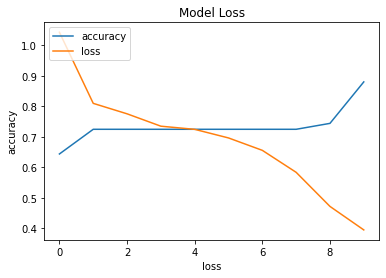

In [115]:
plt.plot(history_0.history['accuracy'])
plt.plot(history_0.history['loss'])
plt.title('Model Loss')
plt.ylabel('accuracy')
plt.xlabel('loss')
plt.legend(['accuracy', 'loss'], loc='upper left')
plt.show()

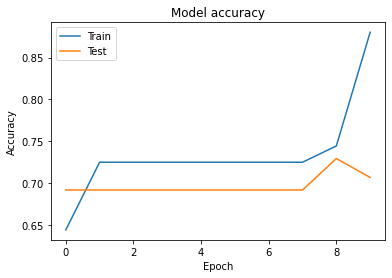

In [116]:
plt.figure()
plt.plot(history_0.history['accuracy'])
plt.plot(history_0.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

### Cluster 1

In [117]:
## Creating model
opt = Adam(learning_rate=0.001, decay=1e-6)

embedding_vector_features=sent_length_1
model1=Sequential()
model1.add(Embedding(voc_size, embedding_vector_features, input_length=sent_length_1))
model1.add(Bidirectional(LSTM(64)))
model1.add(Dense(3, activation='softmax'))
model1.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
print(model1.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 35, 35)            455000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               51200     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 387       
Total params: 506,587
Trainable params: 506,587
Non-trainable params: 0
_________________________________________________________________
None


In [118]:
y_1 = cluster_1['Sentiment']
X_final_1=np.array(embedded_docs_1)
Y_final_1=np.array(y_1)

In [119]:
X_train_1, X_test_1, Y_train_1, Y_test_1 = train_test_split(X_final_1, Y_final_1, test_size=0.30, shuffle=True, random_state=42)

In [120]:
#Training the model
history_1 = model1.fit(X_train_1, Y_train_1, validation_data=(X_test_1, Y_test_1), epochs = 10, batch_size = 32)

Epoch 1/10
6/6 [==============================] - 1s 149ms/step - loss: 1.0816 - accuracy: 0.5215 - val_loss: 1.0111 - val_accuracy: 0.8169
Epoch 2/10
6/6 [==============================] - 0s 25ms/step - loss: 1.0022 - accuracy: 0.6503 - val_loss: 0.8180 - val_accuracy: 0.8169
Epoch 3/10
6/6 [==============================] - 0s 26ms/step - loss: 0.9106 - accuracy: 0.6503 - val_loss: 0.6444 - val_accuracy: 0.8169
Epoch 4/10
6/6 [==============================] - 0s 22ms/step - loss: 0.8785 - accuracy: 0.6503 - val_loss: 0.7086 - val_accuracy: 0.8169
Epoch 5/10
6/6 [==============================] - 0s 23ms/step - loss: 0.8730 - accuracy: 0.6503 - val_loss: 0.7680 - val_accuracy: 0.8169
Epoch 6/10
6/6 [==============================] - 0s 22ms/step - loss: 0.8703 - accuracy: 0.6503 - val_loss: 0.7104 - val_accuracy: 0.8169
Epoch 7/10
6/6 [==============================] - 0s 21ms/step - loss: 0.8326 - accuracy: 0.6503 - val_loss: 0.6237 - val_accuracy: 0.8169
Epoch 8/10
6/6 [==========

In [121]:
Ypred_1=np.argmax(model1.predict(X_test_1), axis=1)

In [122]:
confusion_matrix(Y_test_1, Ypred_1)

array([[58,  0,  0],
       [ 8,  0,  0],
       [ 5,  0,  0]], dtype=int64)

In [123]:
print(classification_report(Y_test_1, Ypred_1))

              precision    recall  f1-score   support

           0       0.82      1.00      0.90        58
           1       0.00      0.00      0.00         8
           2       0.00      0.00      0.00         5

    accuracy                           0.82        71
   macro avg       0.27      0.33      0.30        71
weighted avg       0.67      0.82      0.73        71



C:\Users\Maria Juliana\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Maria Juliana\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Maria Juliana\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


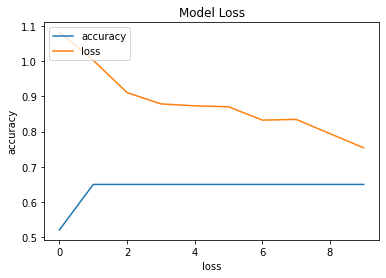

In [124]:
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['loss'])
plt.title('Model Loss')
plt.ylabel('accuracy')
plt.xlabel('loss')
plt.legend(['accuracy', 'loss'], loc='upper left')
plt.show()

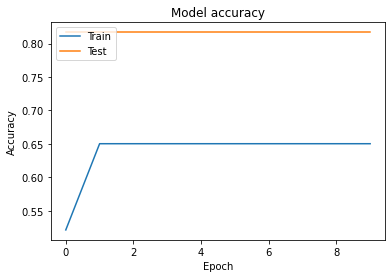

In [125]:
plt.figure()
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

### Cluster 2

In [126]:
## Creating model
opt = Adam(learning_rate=0.001, decay=1e-6)

embedding_vector_features=sent_length_2
model2=Sequential()
model2.add(Embedding(voc_size, embedding_vector_features, input_length=sent_length_2))
model2.add(Bidirectional(LSTM(64)))
model2.add(Dense(3, activation='softmax'))
model2.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
print(model2.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 40, 40)            520000    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               53760     
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 387       
Total params: 574,147
Trainable params: 574,147
Non-trainable params: 0
_________________________________________________________________
None


In [127]:
y_2 = cluster_2['Sentiment']
X_final_2=np.array(embedded_docs_2)
Y_final_2=np.array(y_2)

In [128]:
X_train_2, X_test_2, Y_train_2, Y_test_2 = train_test_split(X_final_2, Y_final_2, test_size=0.30, shuffle=True, random_state=42)

In [129]:
#Training the model
history_2 = model2.fit(X_train_2, Y_train_2, validation_data=(X_test_2, Y_test_2), epochs = 10, batch_size = 32)

Epoch 1/10
19/19 [==============================] - 1s 65ms/step - loss: 0.8860 - accuracy: 0.7487 - val_loss: 0.6737 - val_accuracy: 0.7704
Epoch 2/10
19/19 [==============================] - 0s 26ms/step - loss: 0.7033 - accuracy: 0.7521 - val_loss: 0.6565 - val_accuracy: 0.7704
Epoch 3/10
19/19 [==============================] - 1s 28ms/step - loss: 0.6763 - accuracy: 0.7521 - val_loss: 0.6427 - val_accuracy: 0.7704
Epoch 4/10
19/19 [==============================] - 1s 29ms/step - loss: 0.6257 - accuracy: 0.7521 - val_loss: 0.6107 - val_accuracy: 0.7704
Epoch 5/10
19/19 [==============================] - 1s 27ms/step - loss: 0.4950 - accuracy: 0.7655 - val_loss: 0.5292 - val_accuracy: 0.7860
Epoch 6/10
19/19 [==============================] - 1s 28ms/step - loss: 0.3586 - accuracy: 0.8710 - val_loss: 0.5661 - val_accuracy: 0.7938
Epoch 7/10
19/19 [==============================] - 1s 28ms/step - loss: 0.2381 - accuracy: 0.9246 - val_loss: 0.6126 - val_accuracy: 0.7977
Epoch 8/10
19

In [130]:
Ypred_2=np.argmax(model2.predict(X_test_2), axis=1)

In [131]:
confusion_matrix(Y_test_2, Ypred_2)

array([[180,  16,   2],
       [ 26,  21,   0],
       [  5,   1,   6]], dtype=int64)

In [132]:
print(classification_report(Y_test_2, Ypred_2))

              precision    recall  f1-score   support

           0       0.85      0.91      0.88       198
           1       0.55      0.45      0.49        47
           2       0.75      0.50      0.60        12

    accuracy                           0.81       257
   macro avg       0.72      0.62      0.66       257
weighted avg       0.79      0.81      0.80       257



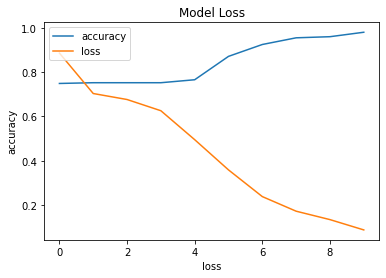

In [133]:
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['loss'])
plt.title('Model Loss')
plt.ylabel('accuracy')
plt.xlabel('loss')
plt.legend(['accuracy', 'loss'], loc='upper left')
plt.show()

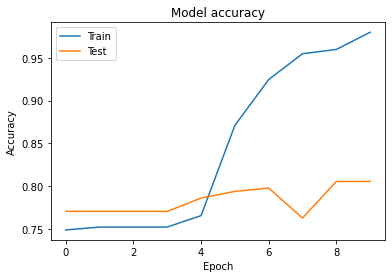

In [134]:
plt.figure()
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

### Cluster 3

In [135]:
## Creating model
opt = Adam(learning_rate=0.001, decay=1e-6)

embedding_vector_features=sent_length_3
model3=Sequential()
model3.add(Embedding(voc_size, embedding_vector_features, input_length=sent_length_3))
model3.add(Bidirectional(LSTM(64)))
model3.add(Dense(3, activation='softmax'))
model3.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
print(model3.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 39, 39)            507000    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               53248     
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 387       
Total params: 560,635
Trainable params: 560,635
Non-trainable params: 0
_________________________________________________________________
None


In [136]:
y_3 = cluster_3['Sentiment']
X_final_3=np.array(embedded_docs_3)
Y_final_3=np.array(y_3)

In [137]:
X_train_3, X_test_3, Y_train_3, Y_test_3 = train_test_split(X_final_3, Y_final_3, test_size=0.30, shuffle=True, random_state=42)

In [138]:
#Training the model
history_3 = model3.fit(X_train_3, Y_train_3, validation_data=(X_test_3, Y_test_3), epochs = 10, batch_size = 32)

Epoch 1/10
160/160 [==============================] - 5s 32ms/step - loss: 0.6018 - accuracy: 0.7879 - val_loss: 0.5082 - val_accuracy: 0.8171
Epoch 2/10
160/160 [==============================] - 4s 28ms/step - loss: 0.4277 - accuracy: 0.8335 - val_loss: 0.4878 - val_accuracy: 0.8075
Epoch 3/10
160/160 [==============================] - 5s 30ms/step - loss: 0.3234 - accuracy: 0.8748 - val_loss: 0.5063 - val_accuracy: 0.7947
Epoch 4/10
160/160 [==============================] - 5s 31ms/step - loss: 0.2450 - accuracy: 0.9053 - val_loss: 0.6079 - val_accuracy: 0.8038
Epoch 5/10
160/160 [==============================] - 5s 29ms/step - loss: 0.1931 - accuracy: 0.9227 - val_loss: 0.6821 - val_accuracy: 0.7965
Epoch 6/10
160/160 [==============================] - 5s 29ms/step - loss: 0.1538 - accuracy: 0.9427 - val_loss: 0.7640 - val_accuracy: 0.7924
Epoch 7/10
160/160 [==============================] - 5s 30ms/step - loss: 0.1319 - accuracy: 0.9536 - val_loss: 0.8087 - val_accuracy: 0.7856

In [139]:
Ypred_3=np.argmax(model3.predict(X_test_3), axis=1)

In [140]:
confusion_matrix(Y_test_3, Ypred_3)

array([[1499,  211,   13],
       [ 205,  169,   14],
       [  33,   18,   30]], dtype=int64)

In [141]:
print(classification_report(Y_test_3, Ypred_3))

              precision    recall  f1-score   support

           0       0.86      0.87      0.87      1723
           1       0.42      0.44      0.43       388
           2       0.53      0.37      0.43        81

    accuracy                           0.77      2192
   macro avg       0.60      0.56      0.58      2192
weighted avg       0.77      0.77      0.77      2192



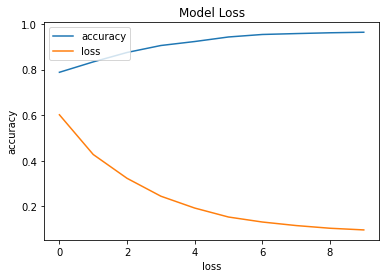

In [142]:
plt.plot(history_3.history['accuracy'])
plt.plot(history_3.history['loss'])
plt.title('Model Loss')
plt.ylabel('accuracy')
plt.xlabel('loss')
plt.legend(['accuracy', 'loss'], loc='upper left')
plt.show()

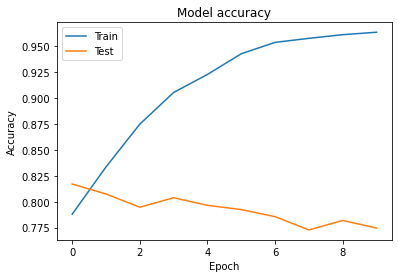

In [143]:
plt.figure()
plt.plot(history_3.history['accuracy'])
plt.plot(history_3.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# =============================================================

# Hyperparametered Tuned BiLSTM

### Cluster 0

In [144]:
## Creating model

#Key differences:
#adam -> adamax
#added epsilon value
#increased decay value (beta_1)
opt = Adamax(learning_rate = 0.001, epsilon = 1e-07, beta_1 = 0.9)

embedding_vector_features = sent_length_0
model0_ht=Sequential()
model0_ht.add(Embedding(voc_size, embedding_vector_features, input_length=sent_length_0))
model0_ht.add(Bidirectional(LSTM(64, use_bias = True, bias_initializer = "zeros")))
model0_ht.add(Dropout(0.2))
model0_ht.add(Dense(3, activation = 'softmax', use_bias = True, bias_initializer = "zeros"))
model0_ht.compile(loss = 'sparse_categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])
print(model0_ht.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 33, 33)            429000    
_________________________________________________________________
bidirectional_4 (Bidirection (None, 128)               50176     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 387       
Total params: 479,563
Trainable params: 479,563
Non-trainable params: 0
_________________________________________________________________
None


In [145]:
y_0_ht = cluster_0['Sentiment']
X_final_0_ht=np.array(embedded_docs_0)
Y_final_0_ht=np.array(y_0)

In [146]:
X_train_0_ht, X_test_0_ht, Y_train_0_ht, Y_test_0_ht = train_test_split(X_final_0_ht, Y_final_0_ht, test_size=0.30, shuffle=True, random_state=42)

In [147]:
#Training the model
history_0_ht = model0_ht.fit(X_train_0_ht, Y_train_0_ht, validation_data=(X_test_0_ht, Y_test_0_ht), epochs = 10, batch_size = 32)

Epoch 1/10
10/10 [==============================] - 1s 92ms/step - loss: 1.0489 - accuracy: 0.6570 - val_loss: 0.9828 - val_accuracy: 0.6917
Epoch 2/10
10/10 [==============================] - 0s 21ms/step - loss: 0.8951 - accuracy: 0.7249 - val_loss: 0.8239 - val_accuracy: 0.6917
Epoch 3/10
10/10 [==============================] - 0s 21ms/step - loss: 0.7767 - accuracy: 0.7249 - val_loss: 0.8152 - val_accuracy: 0.6917
Epoch 4/10
10/10 [==============================] - 0s 23ms/step - loss: 0.7691 - accuracy: 0.7249 - val_loss: 0.7820 - val_accuracy: 0.6917
Epoch 5/10
10/10 [==============================] - 0s 22ms/step - loss: 0.7585 - accuracy: 0.7249 - val_loss: 0.7783 - val_accuracy: 0.6917
Epoch 6/10
10/10 [==============================] - 0s 24ms/step - loss: 0.7497 - accuracy: 0.7249 - val_loss: 0.7776 - val_accuracy: 0.6917
Epoch 7/10
10/10 [==============================] - 0s 23ms/step - loss: 0.7483 - accuracy: 0.7249 - val_loss: 0.7770 - val_accuracy: 0.6917
Epoch 8/10
10

In [148]:
Ypred_0_ht=np.argmax(model0_ht.predict(X_test_0_ht), axis=1)

In [149]:
confusion_matrix(Y_test_0_ht, Ypred_0_ht)

array([[92,  0,  0],
       [31,  0,  0],
       [10,  0,  0]], dtype=int64)

In [150]:
print(classification_report(Y_test_0_ht, Ypred_0_ht))

              precision    recall  f1-score   support

           0       0.69      1.00      0.82        92
           1       0.00      0.00      0.00        31
           2       0.00      0.00      0.00        10

    accuracy                           0.69       133
   macro avg       0.23      0.33      0.27       133
weighted avg       0.48      0.69      0.57       133



C:\Users\Maria Juliana\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Maria Juliana\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Maria Juliana\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


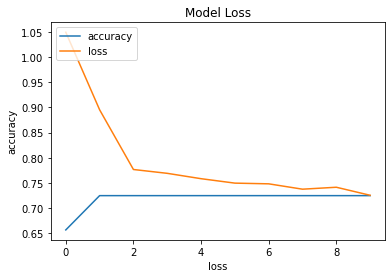

In [151]:
plt.plot(history_0_ht.history['accuracy'])
plt.plot(history_0_ht.history['loss'])
plt.title('Model Loss')
plt.ylabel('accuracy')
plt.xlabel('loss')
plt.legend(['accuracy', 'loss'], loc='upper left')
plt.show()

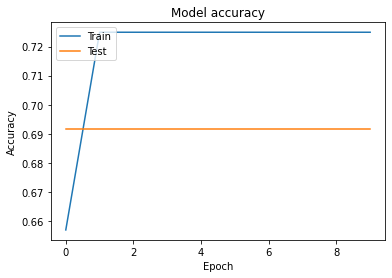

In [152]:
plt.figure()
plt.plot(history_0_ht.history['accuracy'])
plt.plot(history_0_ht.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

### Cluster 1

In [153]:
## Creating model

#Key differences:
#adam -> adamax
#added epsilon value
#increased decay value (beta_1)
opt = Adamax(learning_rate = 0.001, epsilon = 1e-07, beta_1 = 0.9)

embedding_vector_features = sent_length_1
model1_ht=Sequential()
model1_ht.add(Embedding(voc_size, embedding_vector_features, input_length=sent_length_1))
model1_ht.add(Bidirectional(LSTM(64, use_bias = True, bias_initializer = "zeros")))
model1_ht.add(Dropout(0.2))
model1_ht.add(Dense(3, activation = 'softmax', use_bias = True, bias_initializer = "zeros"))
model1_ht.compile(loss = 'sparse_categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])
print(model1_ht.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 35, 35)            455000    
_________________________________________________________________
bidirectional_5 (Bidirection (None, 128)               51200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 387       
Total params: 506,587
Trainable params: 506,587
Non-trainable params: 0
_________________________________________________________________
None


In [154]:
y_1_ht = cluster_1['Sentiment']
X_final_1_ht=np.array(embedded_docs_1)
Y_final_1_ht=np.array(y_1_ht)

In [155]:
X_train_1_ht, X_test_1_ht, Y_train_1_ht, Y_test_1_ht = train_test_split(X_final_1_ht, Y_final_1_ht, test_size=0.30, shuffle=True, random_state=42)

In [156]:
#Training the model
history_1_ht = model1_ht.fit(X_train_1_ht, Y_train_1_ht, validation_data=(X_test_1_ht, Y_test_1_ht), epochs = 10, batch_size = 32)

Epoch 1/10
6/6 [==============================] - 1s 190ms/step - loss: 1.0821 - accuracy: 0.5215 - val_loss: 1.0263 - val_accuracy: 0.8169
Epoch 2/10
6/6 [==============================] - 0s 22ms/step - loss: 1.0356 - accuracy: 0.6503 - val_loss: 0.9502 - val_accuracy: 0.8169
Epoch 3/10
6/6 [==============================] - 0s 30ms/step - loss: 0.9856 - accuracy: 0.6503 - val_loss: 0.8650 - val_accuracy: 0.8169
Epoch 4/10
6/6 [==============================] - 0s 28ms/step - loss: 0.9310 - accuracy: 0.6503 - val_loss: 0.7387 - val_accuracy: 0.8169
Epoch 5/10
6/6 [==============================] - 0s 22ms/step - loss: 0.8872 - accuracy: 0.6503 - val_loss: 0.6444 - val_accuracy: 0.8169
Epoch 6/10
6/6 [==============================] - 0s 26ms/step - loss: 0.9245 - accuracy: 0.6503 - val_loss: 0.6383 - val_accuracy: 0.8169
Epoch 7/10
6/6 [==============================] - 0s 24ms/step - loss: 0.8854 - accuracy: 0.6503 - val_loss: 0.6731 - val_accuracy: 0.8169
Epoch 8/10
6/6 [==========

In [157]:
Ypred_1_ht=np.argmax(model1_ht.predict(X_test_1_ht), axis=1)

In [158]:
confusion_matrix(Y_test_1_ht, Ypred_1_ht)

array([[58,  0,  0],
       [ 8,  0,  0],
       [ 5,  0,  0]], dtype=int64)

In [159]:
print(classification_report(Y_test_1_ht, Ypred_1_ht))

              precision    recall  f1-score   support

           0       0.82      1.00      0.90        58
           1       0.00      0.00      0.00         8
           2       0.00      0.00      0.00         5

    accuracy                           0.82        71
   macro avg       0.27      0.33      0.30        71
weighted avg       0.67      0.82      0.73        71



C:\Users\Maria Juliana\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Maria Juliana\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Maria Juliana\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


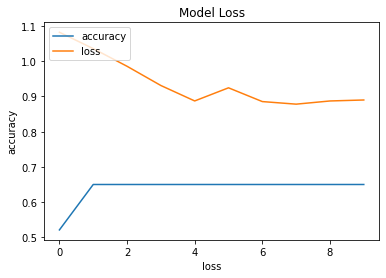

In [160]:
plt.plot(history_1_ht.history['accuracy'])
plt.plot(history_1_ht.history['loss'])
plt.title('Model Loss')
plt.ylabel('accuracy')
plt.xlabel('loss')
plt.legend(['accuracy', 'loss'], loc='upper left')
plt.show()

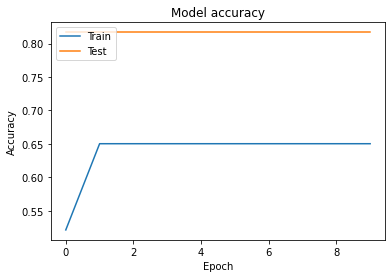

In [161]:
plt.figure()
plt.plot(history_1_ht.history['accuracy'])
plt.plot(history_1_ht.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

### Cluster 2

In [162]:
## Creating model

#Key differences:
#adam -> adamax
#added epsilon value
#increased decay value (beta_1)
opt = Adamax(learning_rate = 0.001, epsilon = 1e-07, beta_1 = 0.9)

embedding_vector_features = sent_length_2
model2_ht=Sequential()
model2_ht.add(Embedding(voc_size, embedding_vector_features, input_length=sent_length_2))
model2_ht.add(Bidirectional(LSTM(64, use_bias = True, bias_initializer = "zeros")))
model2_ht.add(Dropout(0.2))
model2_ht.add(Dense(3, activation = 'softmax', use_bias = True, bias_initializer = "zeros"))
model2_ht.compile(loss = 'sparse_categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])
print(model2_ht.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 40, 40)            520000    
_________________________________________________________________
bidirectional_6 (Bidirection (None, 128)               53760     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 387       
Total params: 574,147
Trainable params: 574,147
Non-trainable params: 0
_________________________________________________________________
None


In [163]:
y_2_ht = cluster_2['Sentiment']
X_final_2_ht=np.array(embedded_docs_2)
Y_final_2_ht=np.array(y_2_ht)

In [164]:
X_train_2_ht, X_test_2_ht, Y_train_2_ht, Y_test_2_ht = train_test_split(X_final_2_ht, Y_final_2_ht, test_size=0.30, shuffle=True, random_state=42)

In [165]:
#Training the model
history_2_ht = model2_ht.fit(X_train_2_ht, Y_train_2_ht, validation_data=(X_test_2_ht, Y_test_2_ht), epochs = 10, batch_size = 32)

Epoch 1/10
19/19 [==============================] - 1s 62ms/step - loss: 0.9485 - accuracy: 0.7387 - val_loss: 0.7202 - val_accuracy: 0.7704
Epoch 2/10
19/19 [==============================] - 0s 25ms/step - loss: 0.7140 - accuracy: 0.7521 - val_loss: 0.6746 - val_accuracy: 0.7704
Epoch 3/10
19/19 [==============================] - 0s 25ms/step - loss: 0.7026 - accuracy: 0.7521 - val_loss: 0.6605 - val_accuracy: 0.7704
Epoch 4/10
19/19 [==============================] - 0s 25ms/step - loss: 0.7020 - accuracy: 0.7521 - val_loss: 0.6563 - val_accuracy: 0.7704
Epoch 5/10
19/19 [==============================] - 1s 32ms/step - loss: 0.6865 - accuracy: 0.7521 - val_loss: 0.6521 - val_accuracy: 0.7704
Epoch 6/10
19/19 [==============================] - 1s 27ms/step - loss: 0.6893 - accuracy: 0.7521 - val_loss: 0.6435 - val_accuracy: 0.7704
Epoch 7/10
19/19 [==============================] - 1s 27ms/step - loss: 0.6724 - accuracy: 0.7521 - val_loss: 0.6358 - val_accuracy: 0.7704
Epoch 8/10
19

In [166]:
Ypred_2_ht=np.argmax(model2_ht.predict(X_test_2_ht), axis=1)

In [167]:
confusion_matrix(Y_test_2_ht, Ypred_2_ht)

array([[198,   0,   0],
       [ 47,   0,   0],
       [ 12,   0,   0]], dtype=int64)

In [168]:
print(classification_report(Y_test_2_ht, Ypred_2_ht))

              precision    recall  f1-score   support

           0       0.77      1.00      0.87       198
           1       0.00      0.00      0.00        47
           2       0.00      0.00      0.00        12

    accuracy                           0.77       257
   macro avg       0.26      0.33      0.29       257
weighted avg       0.59      0.77      0.67       257



C:\Users\Maria Juliana\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Maria Juliana\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Maria Juliana\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


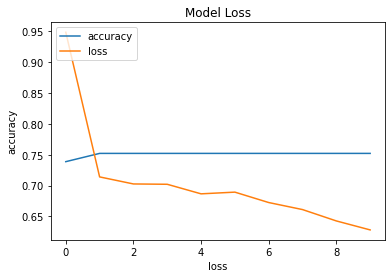

In [169]:
plt.plot(history_2_ht.history['accuracy'])
plt.plot(history_2_ht.history['loss'])
plt.title('Model Loss')
plt.ylabel('accuracy')
plt.xlabel('loss')
plt.legend(['accuracy', 'loss'], loc='upper left')
plt.show()

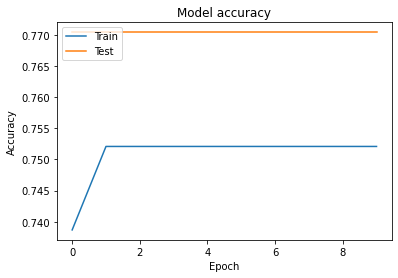

In [170]:
plt.figure()
plt.plot(history_2_ht.history['accuracy'])
plt.plot(history_2_ht.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

### Cluster 3

In [171]:
## Creating model

#Key differences:
#adam -> adamax
#added epsilon value
#increased decay value (beta_1)
opt = Adamax(learning_rate = 0.001, epsilon = 1e-07, beta_1 = 0.9)

embedding_vector_features = sent_length_3
model3_ht=Sequential()
model3_ht.add(Embedding(voc_size, embedding_vector_features, input_length=sent_length_3))
model3_ht.add(Bidirectional(LSTM(64, use_bias = True, bias_initializer = "zeros")))
model3_ht.add(Dropout(0.2))
model3_ht.add(Dense(3, activation = 'softmax', use_bias = True, bias_initializer = "zeros"))
model3_ht.compile(loss = 'sparse_categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])
print(model3_ht.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 39, 39)            507000    
_________________________________________________________________
bidirectional_7 (Bidirection (None, 128)               53248     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 387       
Total params: 560,635
Trainable params: 560,635
Non-trainable params: 0
_________________________________________________________________
None


In [172]:
y_3_ht = cluster_3['Sentiment']
X_final_3_ht=np.array(embedded_docs_3)
Y_final_3_ht=np.array(y_3_ht)

In [173]:
X_train_3_ht, X_test_3_ht, Y_train_3_ht, Y_test_3_ht = train_test_split(X_final_3_ht, Y_final_3_ht, test_size=0.30, shuffle=True, random_state=42)

In [174]:
#Training the model
history_3_ht = model3_ht.fit(X_train_3_ht, Y_train_3_ht, validation_data=(X_test_3_ht, Y_test_3_ht), epochs = 10, batch_size = 32)

Epoch 1/10
160/160 [==============================] - 5s 30ms/step - loss: 0.6520 - accuracy: 0.7860 - val_loss: 0.6062 - val_accuracy: 0.7860
Epoch 2/10
160/160 [==============================] - 4s 25ms/step - loss: 0.5688 - accuracy: 0.7870 - val_loss: 0.5600 - val_accuracy: 0.7860
Epoch 3/10
160/160 [==============================] - 4s 27ms/step - loss: 0.5277 - accuracy: 0.7936 - val_loss: 0.5319 - val_accuracy: 0.7993
Epoch 4/10
160/160 [==============================] - 5s 28ms/step - loss: 0.4989 - accuracy: 0.8144 - val_loss: 0.5141 - val_accuracy: 0.8171
Epoch 5/10
160/160 [==============================] - 5s 28ms/step - loss: 0.4713 - accuracy: 0.8204 - val_loss: 0.5244 - val_accuracy: 0.8093
Epoch 6/10
160/160 [==============================] - 5s 34ms/step - loss: 0.4571 - accuracy: 0.8251 - val_loss: 0.4969 - val_accuracy: 0.8193- ETA: 0s - loss: 0.4
Epoch 7/10
160/160 [==============================] - 5s 31ms/step - loss: 0.4392 - accuracy: 0.8318 - val_loss: 0.4969 -

In [175]:
Ypred_3_ht=np.argmax(model3_ht.predict(X_test_3_ht), axis=1)

In [176]:
confusion_matrix(Y_test_3_ht, Ypred_3_ht)

array([[1648,   75,    0],
       [ 240,  148,    0],
       [  61,   20,    0]], dtype=int64)

In [177]:
print(classification_report(Y_test_3_ht, Ypred_3_ht))

              precision    recall  f1-score   support

           0       0.85      0.96      0.90      1723
           1       0.61      0.38      0.47       388
           2       0.00      0.00      0.00        81

    accuracy                           0.82      2192
   macro avg       0.48      0.45      0.46      2192
weighted avg       0.77      0.82      0.79      2192



C:\Users\Maria Juliana\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Maria Juliana\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Maria Juliana\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


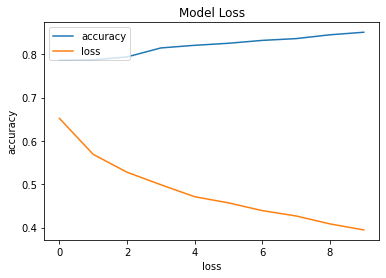

In [178]:
plt.plot(history_3_ht.history['accuracy'])
plt.plot(history_3_ht.history['loss'])
plt.title('Model Loss')
plt.ylabel('accuracy')
plt.xlabel('loss')
plt.legend(['accuracy', 'loss'], loc='upper left')
plt.show()

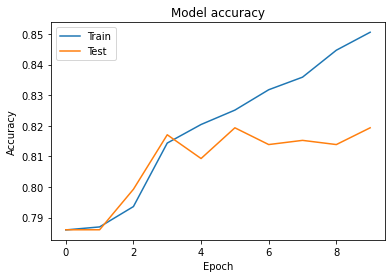

In [179]:
plt.figure()
plt.plot(history_3_ht.history['accuracy'])
plt.plot(history_3_ht.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# =============================================================

## Start of Test Cases

In [22]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dropout
from keras.optimizers import SGD, Adam
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import Adamax
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

#Shapiro Wilk Test with Pingouin
import pingouin as pg

In [2]:
#Load the dataset csv file coming from gdrive
url = 'https://drive.google.com/file/d/1XEoubR4GmzUYH2mcd913NwsREp_dYXGH/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id=' + url.split('/')[-2]
path

'https://drive.google.com/uc?export=download&id=1XEoubR4GmzUYH2mcd913NwsREp_dYXGH'

In [3]:
internet_dataset = pd.read_csv(path, index_col=False)
internet_dataset

,Unnamed: 0,Sentiment,Tweet,Tokenize,Lemmatize,Lang,Cluster
0,0,0,meron akong concern wifi wala wifi days napo b...,"['meron', 'akong', 'concern', 'wifi', 'wala', ...","['meron', 'akong', 'concern', 'wifi', 'wala', ...",Filipino,1
1,1,0,naman sisipagin mag post ig eh pucha di maayos...,"['naman', 'sisipagin', 'mag', 'post', 'ig', 'e...","['naman', 'sisipagin', 'mag', 'post', 'ig', 'e...",Filipino,1
2,2,0,asap,['asap'],['asap'],Filipino,1
3,3,0,hoy di gumagana ig sainyo,"['hoy', 'di', 'gumagana', 'ig', 'sainyo']","['hoy', 'di', 'gumagana', 'ig', 'sainyo']",Filipino,1
4,4,0,samaan ba nng loob n,"['samaan', 'ba', 'nng', 'loob', 'n']","['samaan', 'ba', 'nng', 'loob', 'n']",Filipino,1
...,...,...,...,...,...,...,...
4411,4411,0,converge system upgrade lagi pag nag follow na...,"['converge', 'system', 'upgrade', 'lagi', 'pag...","['converge', 'system', 'upgrade', 'lagi', 'pag...",English,3
4412,4412,0,ehold mins gi disconnect diay call yawa jud,"['ehold', 'mins', 'gi', 'disconnect', 'diay', ...","['ehold', 'min', 'gi', 'disconnect', 'diay', '...",English,3
4413,4413,0,really read messages specific cocnerns templat...,"['really', 'read', 'messages', 'specific', 'co...","['really', 'read', 'message', 'specific', 'coc...",English,3
4414,4414,0,days work lost already los p dm sent,"['days', 'work', 'lost', 'already', 'los', 'p'...","['day', 'work', 'lost', 'already', 'los', 'p',...",English,3


## Test Case 1: Whole Dataset

In [4]:
corpus = internet_dataset['Lemmatize']
voc_size = 13000

In [5]:
onehot_repr=[one_hot (words, voc_size) for words in corpus] 

In [6]:
sent_length=40
embedded_docs=pad_sequences(onehot_repr, padding='pre', maxlen=sent_length)
print(embedded_docs)

[[    0     0     0 ...  6573   809  6884]
 [    0     0     0 ...  3977 11638  2783]
 [    0     0     0 ...     0     0  5674]
 ...
 [    0     0     0 ...  6147  2063 10507]
 [    0     0     0 ...  1823 11168   799]
 [    0     0     0 ...  5762  1142  5541]]


In [7]:
y = internet_dataset['Sentiment']

In [8]:
X_final=np.array(embedded_docs)
Y_final=np.array(y)

In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(X_final, Y_final, test_size=0.30, shuffle=True, random_state=42)

### Default BiLSTM

In [10]:
opt = Adam(learning_rate=0.001, decay=1e-6)
embedding_vector_features=32
defaultTestCase1=Sequential()
defaultTestCase1.add(Embedding(voc_size, embedding_vector_features, input_length=sent_length))
defaultTestCase1.add(Bidirectional(LSTM(64)))
defaultTestCase1.add(Dense(3, activation='softmax'))
defaultTestCase1.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
print(defaultTestCase1.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 40, 32)            416000    
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               49664     
_________________________________________________________________
dense (Dense)                (None, 3)                 387       
Total params: 466,051
Trainable params: 466,051
Non-trainable params: 0
_________________________________________________________________
None


In [11]:
defaultTestCase1.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs = 10, batch_size = 32)

Epoch 1/10
97/97 [==============================] - 4s 40ms/step - loss: 0.5678 - accuracy: 0.8382 - val_loss: 0.4608 - val_accuracy: 0.8634
Epoch 2/10
97/97 [==============================] - 3s 32ms/step - loss: 0.4324 - accuracy: 0.8467 - val_loss: 0.3763 - val_accuracy: 0.8664
Epoch 3/10
97/97 [==============================] - 3s 30ms/step - loss: 0.3135 - accuracy: 0.8771 - val_loss: 0.3677 - val_accuracy: 0.8725
Epoch 4/10
97/97 [==============================] - 4s 38ms/step - loss: 0.2321 - accuracy: 0.9130 - val_loss: 0.4017 - val_accuracy: 0.8657
Epoch 5/10
97/97 [==============================] - 4s 39ms/step - loss: 0.1878 - accuracy: 0.9363 - val_loss: 0.4183 - val_accuracy: 0.8551
Epoch 6/10
97/97 [==============================] - 4s 37ms/step - loss: 0.1264 - accuracy: 0.9566 - val_loss: 0.4623 - val_accuracy: 0.8551
Epoch 7/10
97/97 [==============================] - 3s 32ms/step - loss: 0.0923 - accuracy: 0.9706 - val_loss: 0.5247 - val_accuracy: 0.8423
Epoch 8/10
97

In [12]:
Ypred=np.argmax(defaultTestCase1.predict(X_test), axis=1)

In [13]:
confusion_matrix(Y_test, Ypred)

array([[1062,   77,    5],
       [  87,   53,    3],
       [  19,    9,   10]], dtype=int64)

In [14]:
print(classification_report(Y_test, Ypred))

              precision    recall  f1-score   support

           0       0.91      0.93      0.92      1144
           1       0.38      0.37      0.38       143
           2       0.56      0.26      0.36        38

    accuracy                           0.85      1325
   macro avg       0.62      0.52      0.55      1325
weighted avg       0.84      0.85      0.84      1325



### Tuned BiLSTM

In [15]:
## Creating model
opt = Adamax(learning_rate = 0.001, epsilon = 1e-07, beta_1 = 0.9)
embedding_vector_features = 40
testCase1 = Sequential()
testCase1.add(Embedding(voc_size, embedding_vector_features, input_length=sent_length))
testCase1.add(Bidirectional(LSTM(64, use_bias = True, bias_initializer = "zeros")))
testCase1.add(Dropout(0.2))
testCase1.add(Dense(3, activation = 'softmax', use_bias = True, bias_initializer = "zeros"))
testCase1.compile(loss = 'sparse_categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])
print(testCase1.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 40, 40)            520000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               53760     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 387       
Total params: 574,147
Trainable params: 574,147
Non-trainable params: 0
_________________________________________________________________
None


In [16]:
#Training the model
testCase1.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs = 10, batch_size = 32)

Epoch 1/10
97/97 [==============================] - 5s 49ms/step - loss: 0.6012 - accuracy: 0.8382 - val_loss: 0.4711 - val_accuracy: 0.8634
Epoch 2/10
97/97 [==============================] - 3s 36ms/step - loss: 0.5080 - accuracy: 0.8467 - val_loss: 0.4587 - val_accuracy: 0.8634
Epoch 3/10
97/97 [==============================] - 3s 33ms/step - loss: 0.4884 - accuracy: 0.8467 - val_loss: 0.4334 - val_accuracy: 0.8634
Epoch 4/10
97/97 [==============================] - 3s 30ms/step - loss: 0.4564 - accuracy: 0.8467 - val_loss: 0.4139 - val_accuracy: 0.8634
Epoch 5/10
97/97 [==============================] - 3s 33ms/step - loss: 0.4404 - accuracy: 0.8467 - val_loss: 0.4048 - val_accuracy: 0.8634
Epoch 6/10
97/97 [==============================] - 3s 34ms/step - loss: 0.4189 - accuracy: 0.8470 - val_loss: 0.4011 - val_accuracy: 0.8634
Epoch 7/10
97/97 [==============================] - 3s 35ms/step - loss: 0.3979 - accuracy: 0.8505 - val_loss: 0.3783 - val_accuracy: 0.8642
Epoch 8/10
97

In [17]:
Ypred1=np.argmax(testCase1.predict(X_test), axis=1)

In [18]:
confusion_matrix(Y_test, Ypred1)

array([[1117,   27,    0],
       [ 100,   43,    0],
       [  31,    7,    0]], dtype=int64)

In [19]:
print('TEST CASE 1: TUNED BILSTM WITH WHOLE DATASET \n' + classification_report(Y_test, Ypred1))

TEST CASE 1: TUNED BILSTM WITH WHOLE DATASET 
              precision    recall  f1-score   support

           0       0.90      0.98      0.93      1144
           1       0.56      0.30      0.39       143
           2       0.00      0.00      0.00        38

    accuracy                           0.88      1325
   macro avg       0.48      0.43      0.44      1325
weighted avg       0.83      0.88      0.85      1325



C:\Users\Maria Juliana\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Maria Juliana\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Maria Juliana\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
def analyzeTestCase1(test):
    onehot_repr_test = [one_hot (words, voc_size) for words in test] 
    print(onehot_repr_test)
    sent_length = 40
    embedded_docs_test = pad_sequences(onehot_repr_test, padding='pre', maxlen = sent_length)
    #print(embedded_docs_test)
    pred_test = np.argmax(testCase1.predict(embedded_docs_test), axis=1)

    print(pred_test)
    print('╔════════════════════════════════════════════╗')
    if pred_test == 0:
        print(' Input: ' + str(test[0]))
        print(' Sentiment is Negative' )
    elif pred_test == 1:
        print(' Input: ' + str(test[0]))
        print(' Sentiment is Neutral' )
    else:
        print(' Input: ' + str(test[0]))
        print(' Sentiment is Positive' )
    print('╚════════════════════════════════════════════╝')

In [21]:
analyzeTestCase1(['slow internet. i am disappointed'])

[[11627, 2480, 9640, 10756, 397]]
[0]
╔════════════════════════════════════════════╗
 Input: slow internet. i am disappointed
 Sentiment is Negative
╚════════════════════════════════════════════╝


In [25]:
pg.normality(y)

,W,pval,normal
Sentiment,0.4341,0.0,False


C:\Users\Maria Juliana\anaconda3\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


## Test Case 2: Balanced Dataset with Three Sentiment Classes

In [26]:
#class 0 (negative)
negative_complete = internet_dataset.query("Sentiment == 0");
#class 1 (neutral)
neutral_complete = internet_dataset.query("Sentiment == 1");
#class 2 (positive)
positive_complete = internet_dataset.query("Sentiment == 2");

In [27]:
negative_366 = negative_complete.iloc[:366]
neutral_366 = neutral_complete.iloc[:366]
positive_366 = positive_complete.iloc[:366]

In [28]:
internet_366 = pd.concat([negative_366, neutral_366, positive_366], axis=0)
internet_366 = internet_366.reset_index()

In [29]:
internet_366['Length'] = [len(x.split()) for x in internet_366['Lemmatize'].tolist()]

In [30]:
corpus = internet_366['Lemmatize']

In [31]:
onehot_repr=[one_hot (words, voc_size) for words in corpus]

In [32]:
sent_length = 32
embedded_docs=pad_sequences(onehot_repr, padding='pre', maxlen=sent_length)

In [33]:
y = internet_366['Sentiment']

In [34]:
X_final=np.array(embedded_docs)
Y_final=np.array(y)

In [35]:
X_train, X_test, Y_train, Y_test = train_test_split(X_final, Y_final, test_size=0.30, shuffle=True, random_state=42)

### Default BILSTM

In [36]:
opt = Adam(learning_rate=0.001, decay=1e-6)
embedding_vector_features=32
defaultTestCase2=Sequential()
defaultTestCase2.add(Embedding(voc_size, embedding_vector_features, input_length=sent_length))
defaultTestCase2.add(Bidirectional(LSTM(64)))
defaultTestCase2.add(Dense(3, activation='softmax'))
defaultTestCase2.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
print(defaultTestCase2.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 32, 32)            416000    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               49664     
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 387       
Total params: 466,051
Trainable params: 466,051
Non-trainable params: 0
_________________________________________________________________
None


In [37]:
defaultTestCase2.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs = 10, batch_size = 32)

Epoch 1/10
19/19 [==============================] - 1s 71ms/step - loss: 1.0576 - accuracy: 0.4389 - val_loss: 1.0127 - val_accuracy: 0.4444
Epoch 2/10
19/19 [==============================] - 0s 22ms/step - loss: 0.9935 - accuracy: 0.5528 - val_loss: 0.9942 - val_accuracy: 0.5249
Epoch 3/10
19/19 [==============================] - 1s 30ms/step - loss: 0.9558 - accuracy: 0.5759 - val_loss: 0.9708 - val_accuracy: 0.5249
Epoch 4/10
19/19 [==============================] - 1s 38ms/step - loss: 0.8586 - accuracy: 0.6403 - val_loss: 0.9149 - val_accuracy: 0.5594
Epoch 5/10
19/19 [==============================] - 0s 26ms/step - loss: 0.7139 - accuracy: 0.6815 - val_loss: 0.8640 - val_accuracy: 0.5594
Epoch 6/10
19/19 [==============================] - 0s 26ms/step - loss: 0.5660 - accuracy: 0.7673 - val_loss: 0.8663 - val_accuracy: 0.5862
Epoch 7/10
19/19 [==============================] - 1s 29ms/step - loss: 0.4203 - accuracy: 0.8746 - val_loss: 0.8233 - val_accuracy: 0.6284
Epoch 8/10
19

In [38]:
Ypred=np.argmax(defaultTestCase2.predict(X_test), axis=1)

In [39]:
confusion_matrix(Y_test, Ypred)

array([[64, 47,  0],
       [25, 81,  3],
       [10, 17, 14]], dtype=int64)

In [40]:
print(classification_report(Y_test, Ypred))

              precision    recall  f1-score   support

           0       0.65      0.58      0.61       111
           1       0.56      0.74      0.64       109
           2       0.82      0.34      0.48        41

    accuracy                           0.61       261
   macro avg       0.68      0.55      0.58       261
weighted avg       0.64      0.61      0.60       261



### Tuned BILSTM

In [41]:
opt = Adamax(learning_rate = 0.001, epsilon = 1e-07, beta_1 = 0.9)
embedding_vector_features = 32
testCase2=Sequential()
testCase2.add(Embedding(voc_size, embedding_vector_features, input_length=sent_length))
testCase2.add(Bidirectional(LSTM(64, use_bias = True, bias_initializer = "zeros")))
testCase2.add(Dropout(0.2))
testCase2.add(Dense(3, activation = 'softmax', use_bias = True, bias_initializer = "zeros"))
testCase2.compile(loss = 'sparse_categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])
print(testCase2.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 32, 32)            416000    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               49664     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 387       
Total params: 466,051
Trainable params: 466,051
Non-trainable params: 0
_________________________________________________________________
None


In [42]:
testCase2.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs = 10, batch_size = 32)

Epoch 1/10
19/19 [==============================] - 1s 68ms/step - loss: 1.0526 - accuracy: 0.4571 - val_loss: 1.0166 - val_accuracy: 0.4330
Epoch 2/10
19/19 [==============================] - 0s 23ms/step - loss: 1.0090 - accuracy: 0.4439 - val_loss: 1.0068 - val_accuracy: 0.4521
Epoch 3/10
19/19 [==============================] - 0s 25ms/step - loss: 1.0007 - accuracy: 0.5264 - val_loss: 1.0003 - val_accuracy: 0.5364
Epoch 4/10
19/19 [==============================] - 1s 29ms/step - loss: 0.9924 - accuracy: 0.5396 - val_loss: 0.9922 - val_accuracy: 0.5134
Epoch 5/10
19/19 [==============================] - 0s 26ms/step - loss: 0.9773 - accuracy: 0.5281 - val_loss: 0.9829 - val_accuracy: 0.5364
Epoch 6/10
19/19 [==============================] - 0s 23ms/step - loss: 0.9594 - accuracy: 0.5644 - val_loss: 0.9713 - val_accuracy: 0.5441
Epoch 7/10
19/19 [==============================] - 0s 23ms/step - loss: 0.9439 - accuracy: 0.5611 - val_loss: 0.9630 - val_accuracy: 0.5211
Epoch 8/10
19

In [43]:
Ypred1=np.argmax(testCase2.predict(X_test), axis=1)

In [44]:
print(classification_report(Y_test, Ypred1))

              precision    recall  f1-score   support

           0       0.50      0.68      0.58       111
           1       0.58      0.60      0.59       109
           2       0.00      0.00      0.00        41

    accuracy                           0.54       261
   macro avg       0.36      0.42      0.39       261
weighted avg       0.46      0.54      0.49       261



C:\Users\Maria Juliana\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Maria Juliana\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Maria Juliana\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [45]:
def analyzeTestCase2(test):
    onehot_repr_test = [one_hot (words, voc_size) for words in test] 
    print(onehot_repr_test)
    sent_length = 40
    embedded_docs_test = pad_sequences(onehot_repr_test, padding='pre', maxlen = sent_length)
    #print(embedded_docs_test)
    pred_test = np.argmax(testCase2.predict(embedded_docs_test), axis=1)

    print(pred_test)
    print('╔════════════════════════════════════════════╗')
    if pred_test == 0:
        print(' Input: ' + str(test[0]))
        print(' Sentiment is Negative' )
    elif pred_test == 1:
        print(' Input: ' + str(test[0]))
        print(' Sentiment is Neutral' )
    else:
        print(' Input: ' + str(test[0]))
        print(' Sentiment is Positive' )
    print('╚════════════════════════════════════════════╝')

In [46]:
analyzeTestCase2(['slow internet. i am disappointed'])

[[11627, 2480, 9640, 10756, 397]]
[0]
╔════════════════════════════════════════════╗
 Input: slow internet. i am disappointed
 Sentiment is Negative
╚════════════════════════════════════════════╝


In [47]:
pg.normality(y)

,W,pval,normal
Sentiment,0.783752,2.430401e-32,False


## Test Case 3: Balanced Dataset with Two Sentiment Classes (Neutral & Negative)

In [48]:
negative_50 = negative_complete.iloc[:1593]
neutral_50 = neutral_complete.iloc[:1593]
internet_50 = pd.concat([negative_50, neutral_50], axis=0).reset_index()

In [49]:
internet_50['Length'] = [len(x.split()) for x in internet_50['Lemmatize'].tolist()]

In [50]:
corpus = internet_50['Lemmatize']

In [51]:
onehot_repr=[one_hot (words, voc_size) for words in corpus] 

In [52]:
sent_length = 36
embedded_docs=pad_sequences(onehot_repr, padding='pre', maxlen=sent_length)

In [53]:
y = internet_50['Sentiment']

In [54]:
X_final=np.array(embedded_docs)
Y_final=np.array(y)

In [55]:
X_train, X_test, Y_train, Y_test = train_test_split(X_final, Y_final, test_size=0.30, shuffle=True, random_state=42)

### Default BILSTM

In [56]:
opt = Adam(learning_rate=0.001, decay=1e-6)
embedding_vector_features=36
defaultTestCase3=Sequential()
defaultTestCase3.add(Embedding(voc_size, embedding_vector_features, input_length=sent_length))
defaultTestCase3.add(Bidirectional(LSTM(128)))
defaultTestCase3.add(Dense(2, activation='sigmoid'))
defaultTestCase3.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(defaultTestCase3.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 36, 36)            468000    
_________________________________________________________________
bidirectional_4 (Bidirection (None, 256)               168960    
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 514       
Total params: 637,474
Trainable params: 637,474
Non-trainable params: 0
_________________________________________________________________
None


In [57]:
defaultTestCase3.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs = 10, batch_size = 32)

Epoch 1/10
47/47 [==============================] - 3s 72ms/step - loss: 0.5828 - accuracy: 0.7546 - val_loss: 0.5595 - val_accuracy: 0.7476
Epoch 2/10
47/47 [==============================] - 2s 52ms/step - loss: 0.5122 - accuracy: 0.7566 - val_loss: 0.4693 - val_accuracy: 0.7713
Epoch 3/10
47/47 [==============================] - 2s 50ms/step - loss: 0.3726 - accuracy: 0.8296 - val_loss: 0.4055 - val_accuracy: 0.8139
Epoch 4/10
47/47 [==============================] - 2s 48ms/step - loss: 0.2384 - accuracy: 0.9080 - val_loss: 0.4293 - val_accuracy: 0.8091
Epoch 5/10
47/47 [==============================] - 2s 48ms/step - loss: 0.1643 - accuracy: 0.9331 - val_loss: 0.4759 - val_accuracy: 0.7902
Epoch 6/10
47/47 [==============================] - 3s 57ms/step - loss: 0.1074 - accuracy: 0.9635 - val_loss: 0.5545 - val_accuracy: 0.8013
Epoch 7/10
47/47 [==============================] - 3s 54ms/step - loss: 0.0735 - accuracy: 0.9770 - val_loss: 0.6296 - val_accuracy: 0.8028
Epoch 8/10
47

In [58]:
Ypred=np.argmax(defaultTestCase3.predict(X_test), axis=1)

In [59]:
confusion_matrix(Y_test, Ypred)

array([[419,  55],
       [ 75,  85]], dtype=int64)

In [60]:
print(classification_report(Y_test, Ypred))

              precision    recall  f1-score   support

           0       0.85      0.88      0.87       474
           1       0.61      0.53      0.57       160

    accuracy                           0.79       634
   macro avg       0.73      0.71      0.72       634
weighted avg       0.79      0.79      0.79       634



### Tuned BILSTM

In [61]:
opt = Adamax(learning_rate = 0.001, epsilon = 1e-07, beta_1 = 0.9)
embedding_vector_features = 36
testCase3=Sequential()
testCase3.add(Embedding(voc_size, embedding_vector_features, input_length=sent_length))
testCase3.add(Bidirectional(LSTM(64, use_bias = True, bias_initializer = "zeros")))
testCase3.add(Dropout(0.2))
testCase3.add(Dense(2, activation = 'softmax', use_bias = True, bias_initializer = "zeros"))
testCase3.compile(loss = 'sparse_categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])
print(testCase3.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 36, 36)            468000    
_________________________________________________________________
bidirectional_5 (Bidirection (None, 128)               51712     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 258       
Total params: 519,970
Trainable params: 519,970
Non-trainable params: 0
_________________________________________________________________
None


In [62]:
testCase3.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs = 10, batch_size = 32)

Epoch 1/10
47/47 [==============================] - 2s 42ms/step - loss: 0.5922 - accuracy: 0.7485 - val_loss: 0.5675 - val_accuracy: 0.7476
Epoch 2/10
47/47 [==============================] - 1s 24ms/step - loss: 0.5505 - accuracy: 0.7566 - val_loss: 0.5497 - val_accuracy: 0.7476
Epoch 3/10
47/47 [==============================] - 1s 28ms/step - loss: 0.5148 - accuracy: 0.7566 - val_loss: 0.5100 - val_accuracy: 0.7476
Epoch 4/10
47/47 [==============================] - 1s 28ms/step - loss: 0.4871 - accuracy: 0.7566 - val_loss: 0.4985 - val_accuracy: 0.7476
Epoch 5/10
47/47 [==============================] - 1s 26ms/step - loss: 0.4720 - accuracy: 0.7566 - val_loss: 0.4836 - val_accuracy: 0.7476
Epoch 6/10
47/47 [==============================] - 1s 28ms/step - loss: 0.4534 - accuracy: 0.7681 - val_loss: 0.4778 - val_accuracy: 0.7855
Epoch 7/10
47/47 [==============================] - 1s 26ms/step - loss: 0.4366 - accuracy: 0.7667 - val_loss: 0.4555 - val_accuracy: 0.7744
Epoch 8/10
47

In [63]:
Ypred1=np.argmax(testCase3.predict(X_test), axis=1)

In [64]:
confusion_matrix(Y_test, Ypred1)

array([[468,   6],
       [118,  42]], dtype=int64)

In [65]:
print(classification_report(Y_test, Ypred1))

              precision    recall  f1-score   support

           0       0.80      0.99      0.88       474
           1       0.88      0.26      0.40       160

    accuracy                           0.80       634
   macro avg       0.84      0.62      0.64       634
weighted avg       0.82      0.80      0.76       634



In [66]:
def analyzeTestCase3(test):
    onehot_repr_test = [one_hot (words, voc_size) for words in test] 
    print(onehot_repr_test)
    sent_length = 40
    embedded_docs_test = pad_sequences(onehot_repr_test, padding='pre', maxlen = sent_length)
    #print(embedded_docs_test)
    pred_test = np.argmax(testCase3.predict(embedded_docs_test), axis=1)

    print(pred_test)
    print('╔════════════════════════════════════════════╗')
    if pred_test == 0:
        print(' Input: ' + str(test[0]))
        print(' Sentiment is Negative' )
    elif pred_test == 1:
        print(' Input: ' + str(test[0]))
        print(' Sentiment is Neutral' )
    else:
        print(' Input: ' + str(test[0]))
        print(' Sentiment is Positive' )
    print('╚════════════════════════════════════════════╝')

In [67]:
analyzeTestCase3(['slow internet. i am disappointed'])

[[11627, 2480, 9640, 10756, 397]]
[0]
╔════════════════════════════════════════════╗
 Input: slow internet. i am disappointed
 Sentiment is Negative
╚════════════════════════════════════════════╝


In [72]:
pg.normality(y)

,W,pval,normal
Sentiment,0.535187,0.0,False
